# Time Series Forecasting for Electricity Output using Wind Speed


# Project Background

## 1. Goal
- This project aims to develop a predictive model to forecast the electricity output (CF) of a wind farm based on wind speed data from various locations. The model's performance will be evaluated using the Mean Absolute Error (MAE) metric.
- The primary goal is to build a forecast model that accurately predicts the electricity output (CF) using historical wind speed data.


## 2. Data Source


# Data Schema Review

### Dataset
- **Train Sheet**: Historical data for training the model.
  - Column B – "CF": Target variable (electricity output).
  - Columns C to DJ: Wind speed data from different locations.
- **Predict Sheet**: Data for prediction.

- **112 features**

### Data information
- **Missing Value**: 0
- **Duplicated Value**: 0

# EDA
## Univariate Analysis
- **Numerical Variable Distribution**
    1. Wind Speed Distribution Across 112 Locations:
        - The wind speed distributions across the 112 different locations approximately follow normal or uniform distributions, with no apparent outliers.
    2. Wind Speed Distribution Across All Time Points:
        - The wind speed distributions across all time points also approximately follow normal or uniform distributions, with no apparent outliers.
    3. Central Tendency:
        - The mean and median of the wind speed data are similar, indicating a symmetric distribution.
    4. Decision:
        - Based on these distributions, we extracted the minimum, maximum, and several key percentiles at each time point to represent the characteristics of the wind speed distribution effectively.


- **Categorical Variable Cardinality**
    1. Categorization Based on Time Points: The data is categorized into various time-related features such as year, month, day, season, weekday, and day/night.
    2. The proportion of data points in autumn is higher compared to winter and summer. The data points are evenly distributed between weekdays and weekends. Measurements taken at different times of the day are also uniformly distributed.


## Bivariate analysis
- **Numerical analysis - Correlation**
    1. Our mean wind speed is most correlated with the target value at 0.88, and several other aggregate values also have correlations above 0.7. Therefore, we infer that the distribution of wind speeds from different regions at previous time points is related to the characteristics of the wind speed at the next time point. To avoid overfitting, we can use summary statistics of the wind speeds instead of the original features.

    2. We also checked the wind speeds from different regions, as well as our aggregate wind speed values, for their Pearson and Spearman correlations with the target value. We found that the wind speeds from over 50% of the regions are strongly correlated with the target value.

- **Categorical analysis**
    Based on ANOVA tests, t-tests, and density curves by subgroup, it is evident that there is a strong correlation between seasons and electricity output. Additionally, there is a noticeable relationship between day/night cycles and electricity output.


- **Dual plot：**
    As we can see, MEAN_WS_smooth, P95_WS_smooth, P5_WS_smooth, and electricity output are strongly correlated.

    The analysis reveals that:

    Wind speeds from previous time points influence the current wind speed.
    The current wind speed is strongly correlated with electricity output.
    Thus, it can be concluded that wind speeds from past time points indirectly affect the current electricity output.

## Multivariate Analysis

Based on the coefficients from OLS regression and the feature importance from the decision tree, we explored both the linear and nonlinear relationships between features and the target value. This analysis allowed us to perform an initial feature selection.


# Feature Engineering
The feature engineering process results in a total of **23 features**:

**Numerical Features (19 total)**:

These include the **10 features with the highest correlation to the target value** and **9 key percentiles** at each time point to represent the characteristics of the wind speed distribution.

- Reason for Selection: These features have a strong relationship with the target variable, indicated by their high correlation values.

**Categorical Features (4 total)**:

These features are: **SEASON, DAY_NIGHT, DAY_PART, day_of_week**.

These features were selected based on bar plots, density plots, ANOVA tests, and t-tests, all of which demonstrated their strong relationship with the target variable.

- Reason for Selection: These features exhibit high predictive power for the target variable.
The selected features are expected to provide robust inputs for the predictive model due to their strong associations with the target value.

# Model

### Strategy A（Autogluon Weighted Ensembled L2 regression model）
We use the current time point's wind speed, as well as features such as season and daylight, to predict the electricity output at the current time, without considering the temporal correlation between different time points.


### Strategy B（LSTM， Multivariate time series forecasting model）
We use the wind speed information from previous time points (lagging features) to predict the current electricity output, taking into account the temporal correlation between different time points.

----

# Data Information

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, time, timedelta
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
%matplotlib inline

In [2]:
from scipy.stats import shapiro, normaltest, skew, kurtosis, pearsonr, spearmanr
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import statsmodels.formula.api as smf

In [3]:
# pip install autogluon

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import seaborn as sns
import graphviz
from IPython.display import display, Image
# from pdf2image import convert_from_path

from sklearn.model_selection import train_test_split

from autogluon.tabular import TabularPredictor

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV


In [6]:
data = pd.read_excel('Wind_data.xlsx', sheet_name='Train')
predict = pd.read_excel('Wind_data.xlsx', sheet_name='Predict')
data.head()

,DATETIME,CF,WS_1133733,WS_1156770,WS_1156968,WS_1182195,WS_1193865,WS_1321569,WS_1324653,WS_1358699,WS_1366338,WS_1366351,WS_1369320,WS_1461024,WS_1481513,WS_1504146,WS_1513782,WS_1513805,WS_1571308,WS_1574484,WS_1625339,WS_1625374,WS_1628663,WS_1681085,WS_1820276,WS_1820279,WS_1899876,WS_1911282,WS_1937650,WS_1937653,WS_1953863,WS_1960535,WS_2113254,WS_2113394,WS_2118117,WS_2217107,WS_2379547,WS_2385763,WS_2455069,WS_2460378,WS_2467589,WS_2467635,WS_2479335,WS_2479342,WS_2479346,WS_2503597,WS_2508545,WS_2508550,WS_2586062,WS_593968,WS_594133,WS_609612,WS_629008,WS_629020,WS_631992,WS_651000,WS_676278,WS_676403,WS_676534,WS_72720,WS_72721,WS_72733,WS_73450,WS_73451,WS_73494,WS_73822,WS_74020,WS_74022,WS_74124,WS_74158,WS_74180,WS_74243,WS_745977,WS_746023,WS_74719,WS_74884,WS_751132,WS_75213,WS_75287,WS_75812,WS_75931,WS_75932,WS_75933,WS_75934,WS_75935,WS_75936,WS_75955,WS_76003,WS_76004,WS_76275,WS_76434,WS_76888,WS_77067,WS_77080,WS_77363,WS_77370,WS_77682,WS_77683,WS_77720,WS_77740,WS_77985,WS_78026,WS_78205,WS_78207,WS_78208,WS_811655,WS_839753,WS_875373,WS_883683,WS_883699,WS_914573,WS_918665,WS_920775,WS_921049
0,2019-08-07 00:00:00,0.652524,10.35,8.99,4.57,9.69,8.90,2.90,5.74,1.16,8.81,8.74,11.14,6.13,15.46,10.70,9.66,9.72,11.02,9.90,6.79,2.13,7.31,2.09,6.60,8.17,2.33,3.47,8.04,5.71,9.95,10.27,6.41,6.96,5.75,11.13,10.57,10.45,8.99,9.82,5.84,11.90,6.61,5.71,6.58,11.75,11.55,11.92,6.83,8.89,8.34,10.89,10.59,10.71,11.31,10.27,7.52,6.73,10.52,9.96,9.96,10.94,10.56,9.17,11.67,10.67,10.05,11.78,10.71,10.29,8.32,10.47,11.69,10.88,10.32,9.19,8.80,10.44,11.03,10.24,9.96,9.77,11.00,11.16,11.26,11.55,9.10,9.76,10.44,10.58,11.14,11.13,10.85,10.74,11.06,10.10,9.77,9.93,7.07,10.24,8.72,10.73,10.77,9.82,11.12,6.79,9.31,11.63,10.72,10.55,11.41,10.77,10.17,9.24
1,2019-08-07 01:00:00,0.605852,9.70,8.28,5.78,9.10,7.98,2.23,3.46,0.97,7.75,7.88,10.49,5.84,14.90,10.33,9.59,9.64,9.73,9.48,6.43,1.47,6.96,1.44,6.12,7.42,2.25,2.66,7.70,5.53,10.33,9.60,5.82,6.35,5.63,11.29,10.23,10.72,8.92,9.21,5.35,11.25,6.18,5.58,6.14,11.67,11.73,11.99,6.29,7.95,7.96,10.25,9.98,10.04,11.45,10.33,6.92,5.58,9.79,10.74,9.92,11.03,10.64,8.67,11.65,10.88,9.43,11.75,10.04,9.63,7.65,10.69,11.03,10.99,9.65,9.02,7.95,10.35,11.07,9.51,10.74,9.77,11.11,11.42,11.53,11.73,8.13,9.05,9.82,10.77,10.49,11.15,10.22,10.62,11.35,9.96,9.77,9.97,6.65,9.51,7.76,10.39,10.12,9.21,10.47,6.40,9.50,11.10,11.02,9.91,11.16,10.98,10.16,9.09
2,2019-08-07 02:00:00,0.564094,9.04,7.39,6.21,8.98,7.78,1.98,2.62,0.92,7.55,7.70,10.12,5.81,14.22,10.01,9.59,9.63,8.92,9.11,5.99,1.23,7.09,1.21,5.92,6.91,2.30,2.64,7.30,5.25,10.64,8.90,5.60,6.00,5.62,11.36,9.92,10.22,9.01,8.40,5.09,10.86,5.99,5.58,5.96,11.37,11.73,11.90,6.03,7.81,7.55,9.76,9.69,9.58,11.45,10.35,6.72,5.26,9.28,10.71,9.91,11.04,10.67,8.30,11.49,10.99,8.69,11.59,9.58,8.98,7.20,10.78,10.60,11.02,9.00,8.95,7.61,10.16,11.01,9.26,10.71,9.78,11.14,11.54,11.62,11.73,7.90,8.16,9.25,10.85,10.12,11.06,9.78,10.37,11.47,9.75,9.78,9.99,6.43,9.26,7.64,9.93,9.61,8.40,10.10,6.23,9.46,10.74,11.19,9.52,11.00,11.10,10.04,9.04
3,2019-08-07 03:00:00,0.532721,8.78,7.49,6.43,8.84,7.82,1.33,2.43,0.68,7.53,7.77,9.65,5.32,13.53,9.99,9.44,9.47,8.60,8.82,5.86,1.39,6.86,1.37,5.56,6.84,1.79,3.09,7.24,5.23,10.72,8.70,5.86,5.82,5.66,11.38,9.90,10.49,9.35,8.24,4.85,10.76,5.88,5.62,5.87,11.25,11.74,11.84,5.91,7.85,7.50,9.36,9.32,9.22,11.44,10.32,6.88,4.61,9.18,9.84,9.78,11.00,10.63,8.16,11.37,11.07,8.47,11.46,9.22,8.75,6.84,10.87,10.50,10.99,8.76,8.81,7.65,10.01,10.93,9.04,9.84,9.71,11.12,11.60,11.68,11.74,7.92,8.16,8.91,10.93,9.65,10.96,9.41,10.19,11.55,9.60,9.71,9.97,6.22,9.04,7.70,9.57,9.22,8.24,9.67,6.01,9.45,10.65,11.27,9.11,10.93,11.18,10.20,8.89
4,2019-08-07 04:00:00,0.495608,8.23,6.88,6.81,8.52,6.65,1.64,2.45,0.59,6.40,6.60,9.21,5.25,12.84,9.31,9.20,9.22,7.19,8.63,5.22,1.69,5.90,1.66,4.85,6.61,1.90,3.40,7.21,5.29,10.46,8.13,5.61,5.69,5.60,10.98,9.25,10.62,9.18,7.61,4.48,9.94,5.81,5.55,5.80,10.77,11.22,11.35,5.82,6.63,7.43,8.85,8.99,8.96,10.99,10.03,6.64,3.97,8.34,

In [7]:
predict.head()

,DATETIME,CF,WS_1133733,WS_1156770,WS_1156968,WS_1182195,WS_1193865,WS_1321569,WS_1324653,WS_1358699,WS_1366338,WS_1366351,WS_1369320,WS_1461024,WS_1481513,WS_1504146,WS_1513782,WS_1513805,WS_1571308,WS_1574484,WS_1625339,WS_1625374,WS_1628663,WS_1681085,WS_1820276,WS_1820279,WS_1899876,WS_1911282,WS_1937650,WS_1937653,WS_1953863,WS_1960535,WS_2113254,WS_2113394,WS_2118117,WS_2217107,WS_2379547,WS_2385763,WS_2455069,WS_2460378,WS_2467589,WS_2467635,WS_2479335,WS_2479342,WS_2479346,WS_2503597,WS_2508545,WS_2508550,WS_2586062,WS_593968,WS_594133,WS_609612,WS_629008,WS_629020,WS_631992,WS_651000,WS_676278,WS_676403,WS_676534,WS_72720,WS_72721,WS_72733,WS_73450,WS_73451,WS_73494,WS_73822,WS_74020,WS_74022,WS_74124,WS_74158,WS_74180,WS_74243,WS_745977,WS_746023,WS_74719,WS_74884,WS_751132,WS_75213,WS_75287,WS_75812,WS_75931,WS_75932,WS_75933,WS_75934,WS_75935,WS_75936,WS_75955,WS_76003,WS_76004,WS_76275,WS_76434,WS_76888,WS_77067,WS_77080,WS_77363,WS_77370,WS_77682,WS_77683,WS_77720,WS_77740,WS_77985,WS_78026,WS_78205,WS_78207,WS_78208,WS_811655,WS_839753,WS_875373,WS_883683,WS_883699,WS_914573,WS_918665,WS_920775,WS_921049
0,2020-01-09 00:00:00,NaN,1.69,1.88,3.15,0.92,2.27,1.14,1.24,2.98,2.53,2.18,1.55,1.59,1.10,2.09,1.44,1.43,1.23,1.51,1.15,1.22,2.29,1.24,1.09,0.83,2.78,2.28,1.42,1.77,10.07,2.01,2.50,3.04,3.20,1.38,2.08,9.10,1.16,1.98,1.60,1.44,3.25,3.18,3.18,0.83,1.18,1.08,3.20,2.40,1.27,1.68,0.98,0.93,1.34,1.31,1.90,1.28,1.99,1.44,1.39,1.42,1.35,1.02,1.31,1.08,1.52,1.28,0.93,2.13,1.54,0.97,1.61,1.38,2.09,1.47,2.08,1.50,1.47,0.77,1.44,1.35,1.41,1.24,1.16,1.18,2.40,1.95,1.44,1.05,1.55,1.45,1.19,1.39,1.17,1.47,1.35,1.31,1.35,0.77,2.38,1.94,1.95,1.98,1.40,1.27,1.27,1.43,1.28,1.91,1.12,1.15,1.35,1.46
1,2020-01-09 01:00:00,NaN,1.60,2.02,3.91,0.44,2.36,1.15,1.63,2.83,2.84,2.20,1.17,1.66,1.28,2.43,1.38,1.37,1.95,1.49,1.65,1.46,2.33,1.49,1.10,1.19,2.79,2.45,1.03,1.37,9.97,2.04,1.72,4.72,4.62,1.60,2.46,8.29,1.03,2.13,3.25,2.14,4.95,4.60,4.88,1.11,1.24,0.92,4.97,2.58,0.89,1.41,0.83,1.04,1.47,1.37,1.26,1.22,3.38,1.37,1.38,1.52,1.45,0.80,1.07,1.21,1.42,1.01,1.04,2.15,1.68,1.06,2.43,1.50,2.10,1.27,2.08,1.31,1.47,0.79,1.37,1.32,1.54,1.53,1.37,1.24,2.57,2.10,1.22,1.16,1.17,1.39,0.86,1.11,1.46,1.29,1.32,1.31,1.13,0.79,2.67,1.71,1.85,2.13,1.02,1.11,1.43,2.04,1.60,1.57,1.03,1.28,1.49,1.29
2,2020-01-09 02:00:00,NaN,1.79,2.14,4.20,0.65,2.06,1.28,2.36,3.07,2.34,1.94,1.55,1.82,1.29,3.49,1.64,1.60,2.94,1.68,1.92,1.31,2.05,1.28,0.90,0.80,2.04,3.24,0.81,1.00,9.79,2.17,1.37,5.27,5.17,1.71,3.62,7.65,0.91,2.22,3.64,3.28,5.60,5.14,5.68,0.97,1.26,0.86,5.64,2.14,0.79,1.69,1.03,1.39,1.52,1.62,1.04,1.31,4.59,1.61,1.59,1.60,1.63,0.85,1.14,1.50,1.62,1.11,1.39,2.26,1.64,1.35,3.63,1.62,2.22,1.54,2.03,1.35,1.48,0.88,1.61,1.65,1.63,1.65,1.42,1.26,2.17,2.20,1.49,1.45,1.33,1.40,1.18,1.31,1.57,1.34,1.65,1.63,1.43,0.88,2.19,1.93,1.99,2.22,1.39,1.42,1.42,2.91,1.81,1.85,1.10,1.56,1.54,1.56
3,2020-01-09 03:00:00,NaN,2.01,2.32,5.17,0.51,2.31,0.83,3.39,3.38,2.53,2.26,1.73,1.72,1.04,2.77,2.27,2.19,3.73,1.78,2.39,1.63,2.11,1.61,0.82,1.12,3.18,3.37,0.89,0.91,9.72,2.47,1.52,5.47,4.98,2.19,2.91,6.99,0.78,1.80,3.59,2.99,5.54,4.97,5.59,1.05,1.60,1.19,5.71,2.48,0.86,1.91,1.18,1.51,1.94,2.27,1.11,1.50,4.72,2.23,2.18,2.10,2.23,0.89,1.54,2.06,1.79,1.48,1.51,2.59,1.78,1.88,3.50,2.14,2.54,2.16,2.17,1.77,1.93,1.03,2.23,2.36,2.12,2.00,1.73,1.61,2.37,2.43,1.66,2.07,1.73,1.85,1.31,1.59,1.87,1.73,2.36,2.39,1.81,1.03,2.52,2.21,2.31,1.80,1.55,2.01,1.26,2.49,2.09,2.09,1.06,2.12,1.66,2.18
4,2020-01-09 04:00:00,NaN,2.12,2.54,4.19,0.77,4.52,0.97,2.89,3.79,4.21,4.46,1.58,2.23,1.08,1.83,2.69,2.60,2.15,1.94,3.08,1.90,4.61,1.88,1.10,1.36,3.21,4.67,0.89,0.92,9.26,2.49,1.13,6.49,5.18,2.45,1.78,5.59,1.24,2.59,4.49,1.40,6.07,5.18,6.09,0.89,1.81,1.39,6.35,4.43,0.85,1.98,1.28,1.63,2.22,2.66,0.92,1.52,2.64,2.64,2.59,2.46,2.62,0.91,1.81,2.29,1.97,1.73,1.63,2.56,2.01,2.13,1.63,2.51,2.53,2.58,4.52,2.15,2.32,1.16,2.64,2.78,2.45,2.17,1.91,1.81,4.58,2.58,1.81,2.36,1.58,2.22,1.43,1.86,2.03,2.11,2.78,2.80,2.17,1.16,4.

In [8]:
data.shape

(3635, 114)

In [9]:
predict.shape

(93, 114)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3635 entries, 0 to 3634
Columns: 114 entries, DATETIME to WS_921049
dtypes: datetime64[ns](1), float64(113)
memory usage: 3.2 MB


In [11]:
data.describe()

,DATETIME,CF,WS_1133733,WS_1156770,WS_1156968,WS_1182195,WS_1193865,WS_1321569,WS_1324653,WS_1358699,WS_1366338,WS_1366351,WS_1369320,WS_1461024,WS_1481513,WS_1504146,WS_1513782,WS_1513805,WS_1571308,WS_1574484,WS_1625339,WS_1625374,WS_1628663,WS_1681085,WS_1820276,WS_1820279,WS_1899876,WS_1911282,WS_1937650,WS_1937653,WS_1953863,WS_1960535,WS_2113254,WS_2113394,WS_2118117,WS_2217107,WS_2379547,WS_2385763,WS_2455069,WS_2460378,WS_2467589,WS_2467635,WS_2479335,WS_2479342,WS_2479346,WS_2503597,WS_2508545,WS_2508550,WS_2586062,WS_593968,WS_594133,WS_609612,WS_629008,WS_629020,WS_631992,WS_651000,WS_676278,WS_676403,WS_676534,WS_72720,WS_72721,WS_72733,WS_73450,WS_73451,WS_73494,WS_73822,WS_74020,WS_74022,WS_74124,WS_74158,WS_74180,WS_74243,WS_745977,WS_746023,WS_74719,WS_74884,WS_751132,WS_75213,WS_75287,WS_75812,WS_75931,WS_75932,WS_75933,WS_75934,WS_75935,WS_75936,WS_75955,WS_76003,WS_76004,WS_76275,WS_76434,WS_76888,WS_77067,WS_77080,WS_77363,WS_77370,WS_77682,WS_77683,WS_77720,WS_77740,WS_77985,WS_78026,WS_78205,WS_78207,WS_78208,WS_811655,WS_839753,WS_875373,WS_883683,WS_883699,WS_914573,WS_918665,WS_920775,WS_921049
count,3635,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.00000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000,3635.000000
mean,2019-10-22 23:15:08.170564096,0.186114,4.532563,3.943094,5.124113,5.118909,5.558190,2.524281,3.927272,3.388721,5.787298,5.400131,5.113265,3.082812,5.11004,4.746591,5.601653,5.616028,4.737436,5.419089,4.611172,3.048772,4.935458,3.007634,4.193014,4.868281,4.623131,4.751107,5.365917,4.848912,8.409858,4.425622,5.628596,4.070714,3.789662,6.180083,4.750312,7.908671,5.288048,4.301199,3.745168,4.940121,3.959948,3.775190,3.911803,5.862967,6.320652,6.363132,4.011699,5.691146,5.350600,4.812928,5.290014,5.211409,6.244582,5.792254,5.617801,3.790268,4.716799,5.839609,5.689281,6.088477,5.920525,5.356691,6.300305,5.900298,4.482239,6.324001,5.212157,4.463615,3.742041,5.787191,4.932922,6.055241,4.464967,5.412726,5.399583,5.895950,6.135318,5.290395,5.841851,5.612688,6.115190,6.246078,6.286209,6.320492,5.719968,4.190906,4.717487,5.846501,5.115040,6.167868,5.149120,6.021008,6.236454,5.740915,5.612688,5.659557,4.755939,5.289847,5.668107,5.904085,4.711924,4.306805,5.126252,4.689553,5.455680,4.789538,6.083490,4.860514,5.756882,5.958355,5.699761,5.435894
min,2019-08-07 00:00:00,0.003551,0.590000,0.490000,0.680000,0.460000,0.530000,0.500000,0.310000,0.240000,0.570000,0.510000,0.660000,0.330000,0.46000,0.580000,0.540000,0.490000,0.410000,0.560000,0.690000,0.320000,0.530000,0.320000,0.450000,0.410000,0.560000,0.430000,0.590000,0.510000,0.800000,0.530000,0.560000,0.520000,0.480000,0.650000,0.580000,0.970000,0.420000,0.560000,0.360000,0.480000,0.430000,0.480000,0.390000,0.470000,0.460000,0.430000,

### No Missing Value

In [12]:
sum(data.isnull().any())

0

### No Duplicated values

In [13]:
data.duplicated().value_counts()

False    3635
Name: count, dtype: int64

# Exploratory Data Analysis

In [14]:
# Make sure the data is sorted by datetime
data.set_index('DATETIME', inplace=True)

# Get all columns of Wind Speed from different locations
ws_columns = [col for col in data.columns if col.startswith('WS_')]

In [15]:
predict.set_index('DATETIME', inplace=True)

# EDA
## Univariate Analysis
- Numerical Variable Distribution

In [16]:
# Determine Distribution
def determine_distribution(df):
    """
    Analyzes the distribution characteristics of each column in a DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame to analyze.

    Returns:
        pd.DataFrame: A DataFrame summarizing the distribution characteristics of each column.
    """
    results = []
    for column in df.columns:
        data = df[column]

        # Calculate max, min, mean, std, and median
        max_val = data.max()
        min_val = data.min()
        mean_val = data.mean()
        std_val = data.std()
        median_val = data.median()

        # Normality tests
        stat, p_value_normal = shapiro(data)
        stat_k2, p_value_k2 = normaltest(data)

        # Skewness and kurtosis
        skewness = skew(data)
        kurt = kurtosis(data)

        # Determine distribution type
        if p_value_normal > 0.05 and p_value_k2 > 0.05:
            dist_type = 'Normal Distribution'
        elif np.abs(skewness) < 0.5 and np.abs(kurt) < 3:
            dist_type = 'Uniform Distribution'
        else:
            dist_type = 'Skewed Distribution'

        results.append({
            'Column': column,
            'Min': min_val,
            'Median': median_val,
            'Max': max_val,
            'Mean': mean_val,
            'Std': std_val,
            'Distribution Type': dist_type
        })

    return pd.DataFrame(results)

In [17]:
distribution_results = determine_distribution(data.drop('CF', axis=1))
distribution_results

,Column,Min,Median,Max,Mean,Std,Distribution Type
0,WS_1133733,0.59,3.66,14.66,4.532563,2.790853,Skewed Distribution
1,WS_1156770,0.49,3.22,13.13,3.943094,2.371923,Skewed Distribution
2,WS_1156968,0.68,4.78,14.64,5.124113,2.712505,Skewed Distribution
3,WS_1182195,0.46,4.49,23.04,5.118909,3.213767,Skewed Distribution
4,WS_1193865,0.53,5.36,17.43,5.558190,2.691479,Uniform Distribution
5,WS_1321569,0.50,2.01,13.20,2.524281,1.655931,Skewed Distribution
6,WS_1324653,0.31,3.34,11.81,3.927272,2.398751,Skewed Distribution
7,WS_1358699,0.24,2.46,19.15,3.388721,2.834749,Skewed Distribution
8,WS_1366338,0.57,5.63,17.09,5.787298,2.834219,Uniform Distribution
9,WS_1366351,0.51,5.23,17.37,5.400131,2.608748,Uniform Distribution


In [18]:
distribution_results_df = distribution_results['Distribution Type'].value_counts().reset_index()
distribution_results_df

,Distribution Type,count
0,Skewed Distribution,93
1,Uniform Distribution,19


There are 93 features follow Skewed Distribution, 19 features follow Uniform Distribution.

In [19]:
column_Skewed = distribution_results[distribution_results['Distribution Type'] == 'Skewed Distribution']['Column']
column_Uniform = distribution_results[distribution_results['Distribution Type'] == 'Uniform Distribution']['Column']

In [20]:
def plot_histograms(df, batch_size=10):
    """
    Plots histograms for the columns in the DataFrame in batches.

    Args:
        df (pd.DataFrame): The input DataFrame.
        batch_size (int): The number of columns to include in each batch of histograms.
    """
    num_columns = len(df.columns)
    for start in range(0, num_columns, batch_size):
        end = min(start + batch_size, num_columns)
        columns_batch = df.columns[start:end]
        df[columns_batch].hist(figsize=(15, 10), bins=20)
        plt.tight_layout()
        plt.show()

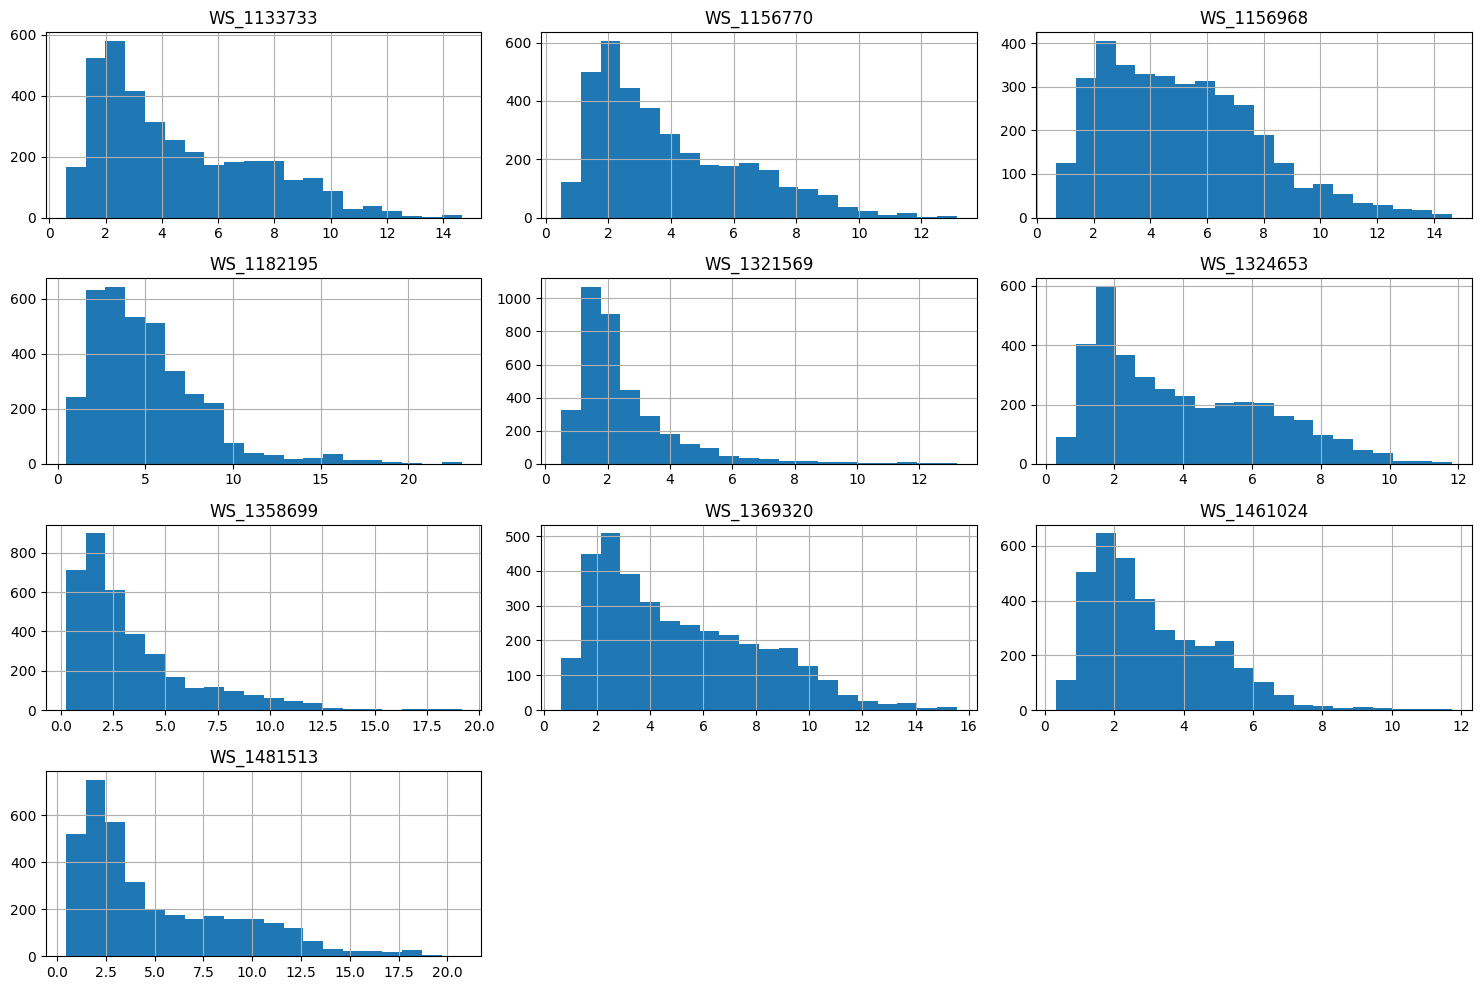

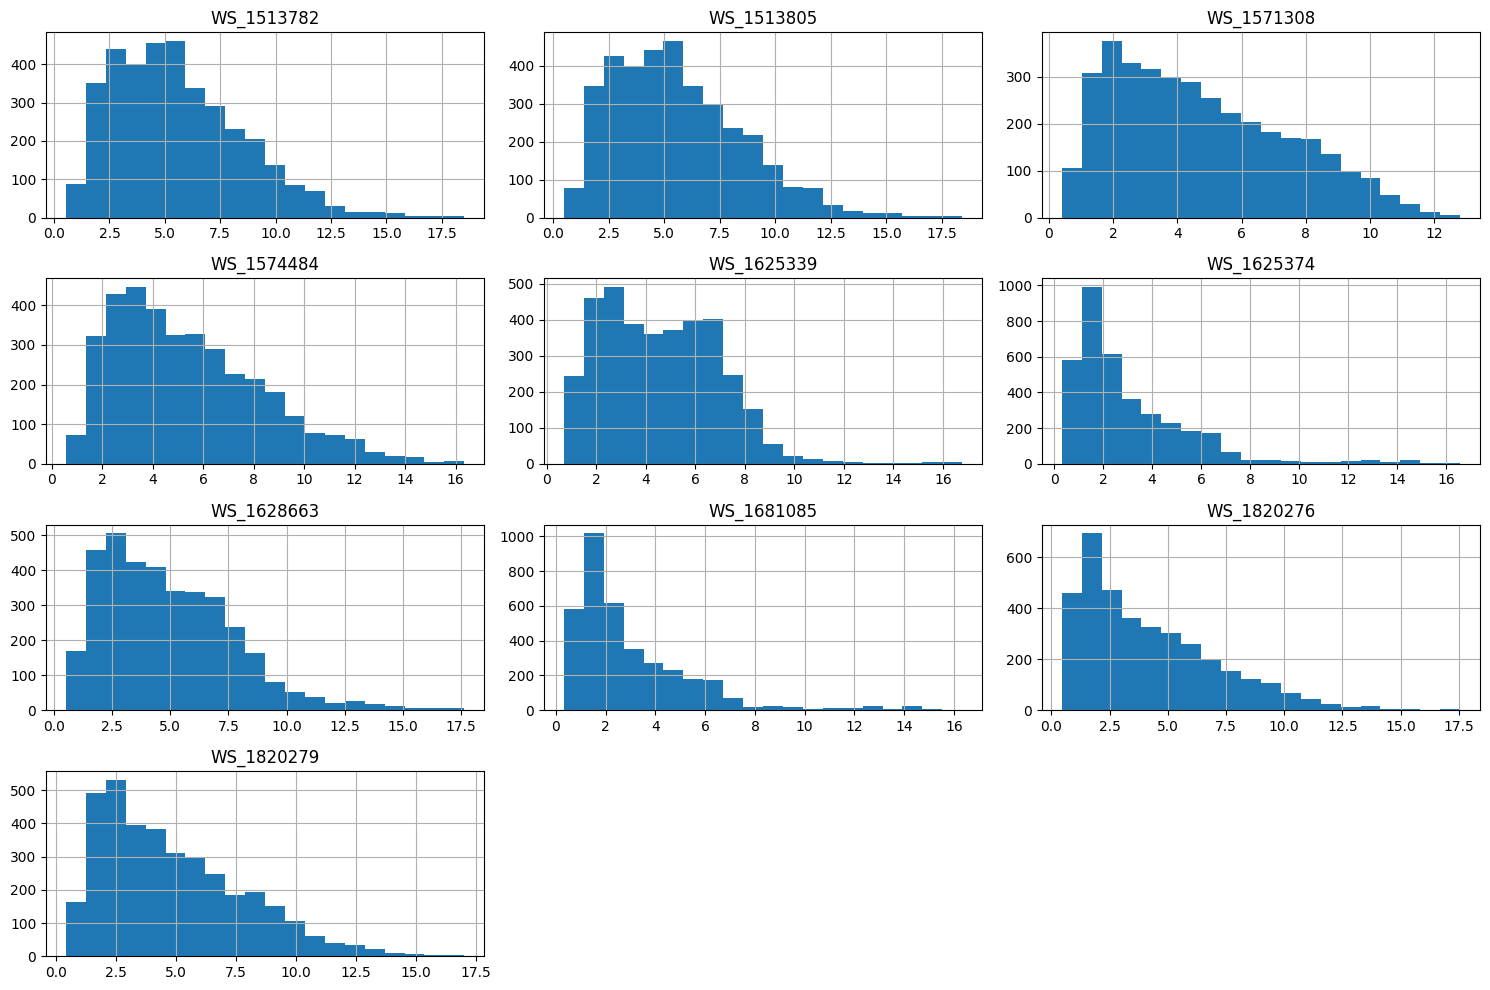

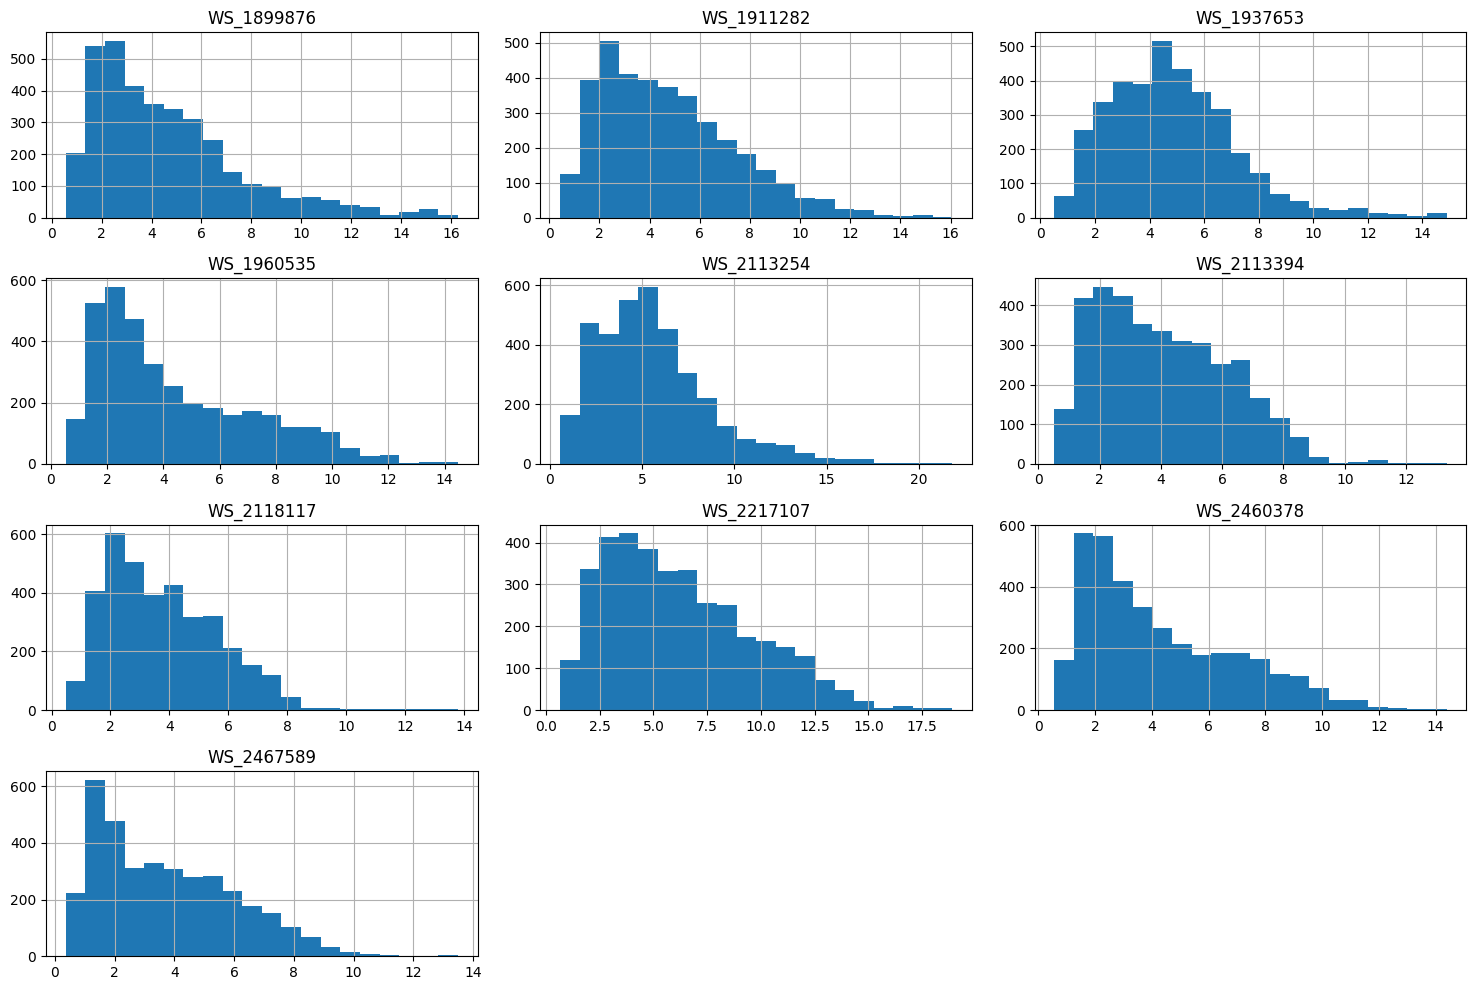

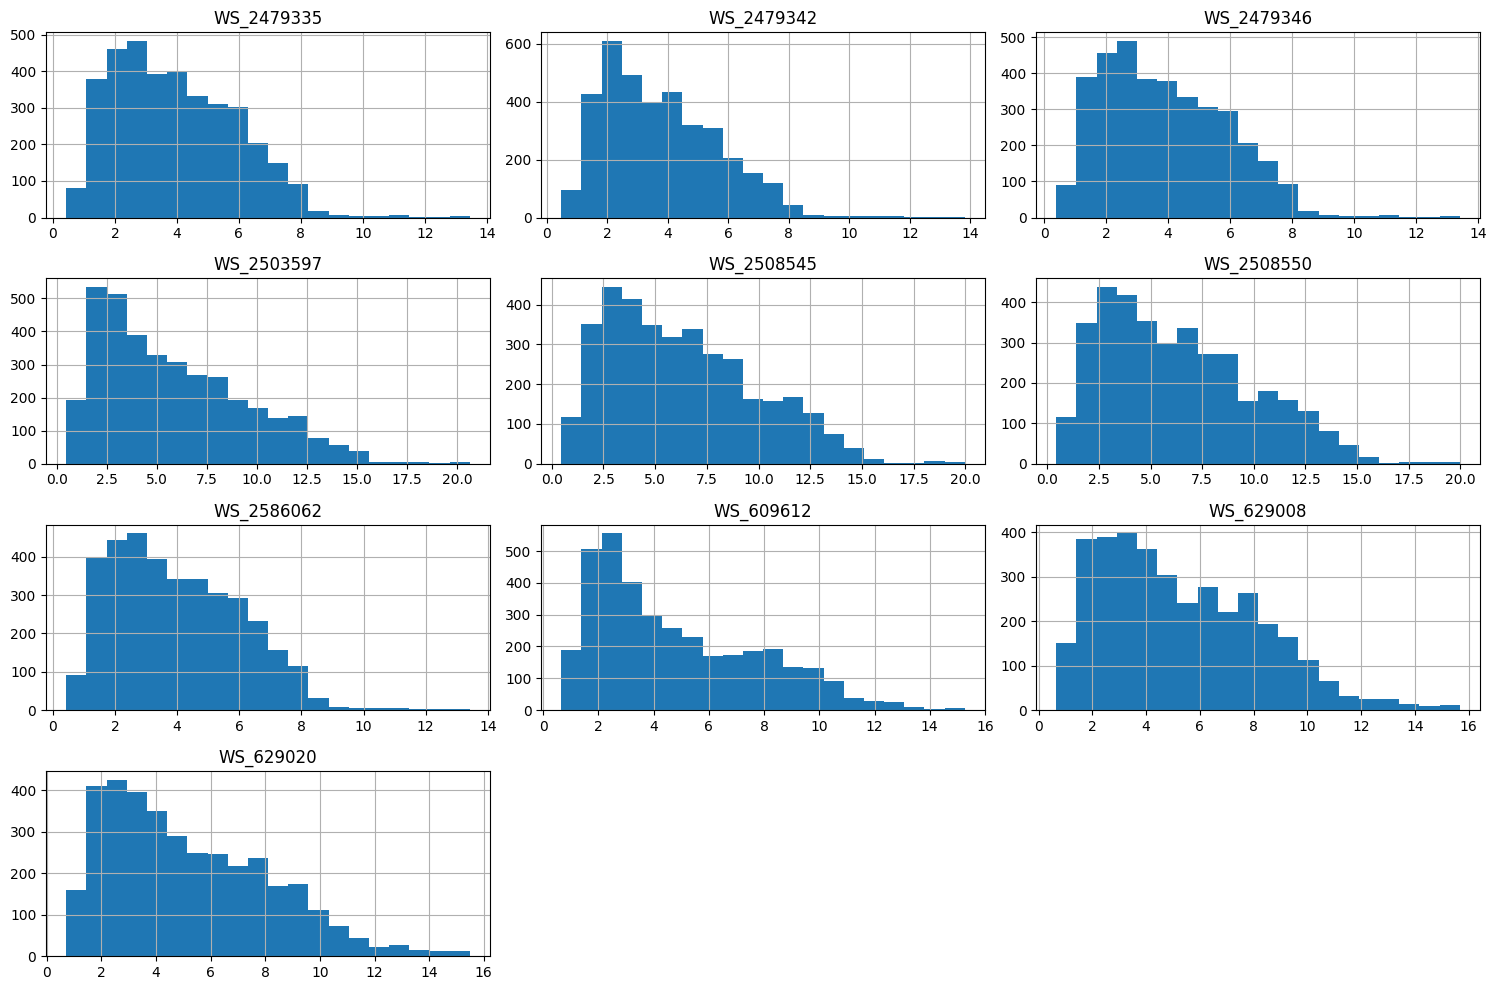

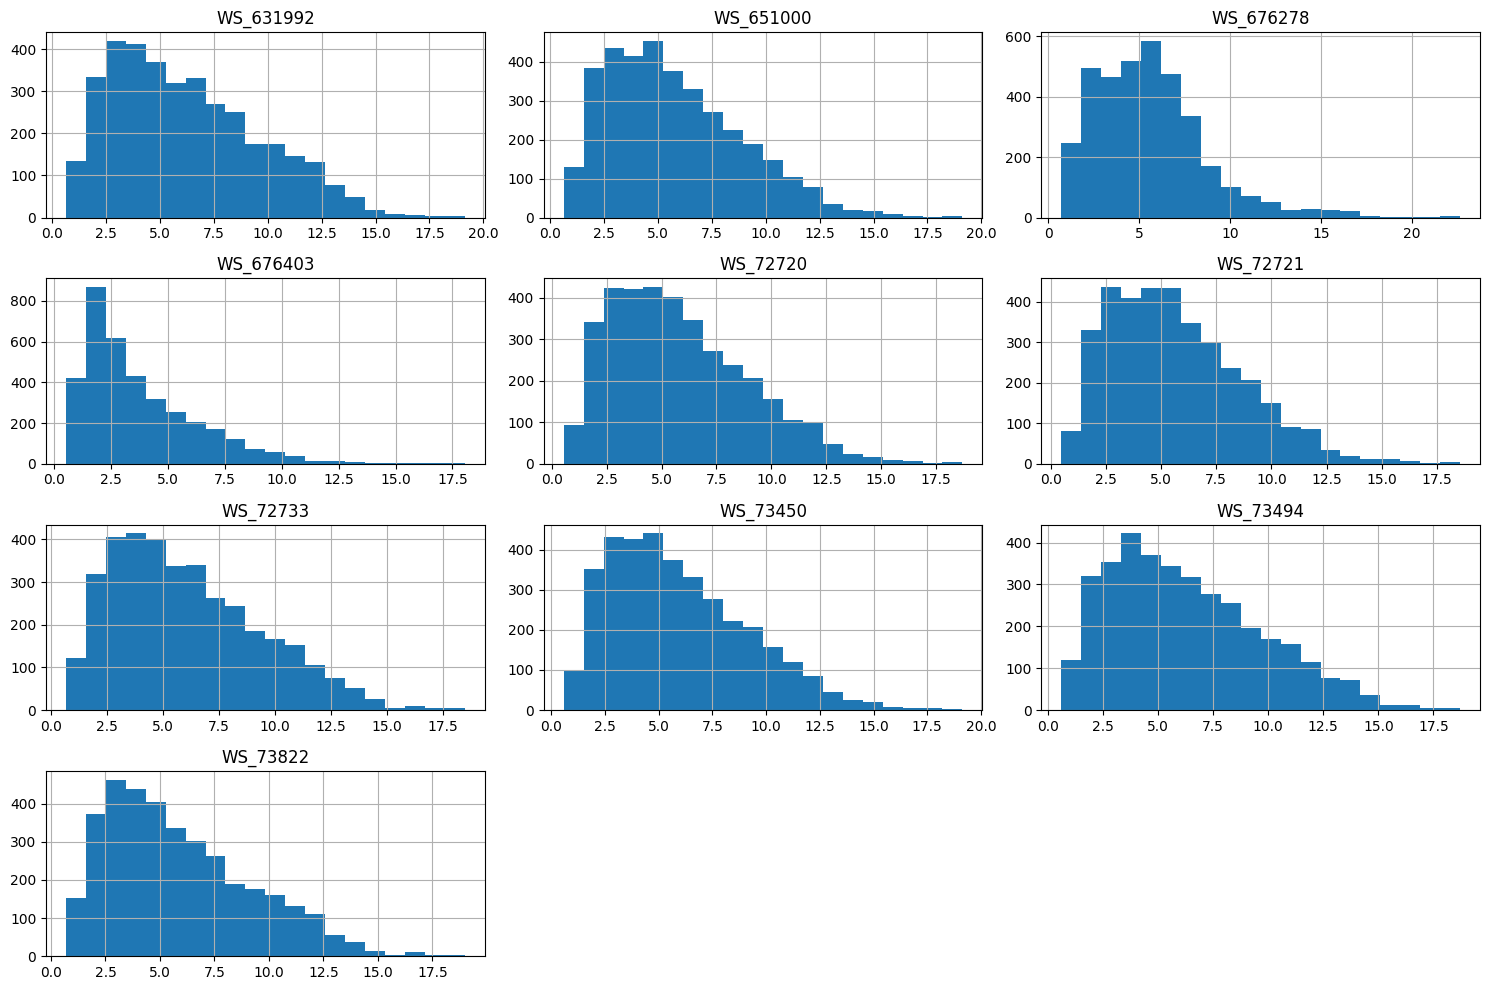

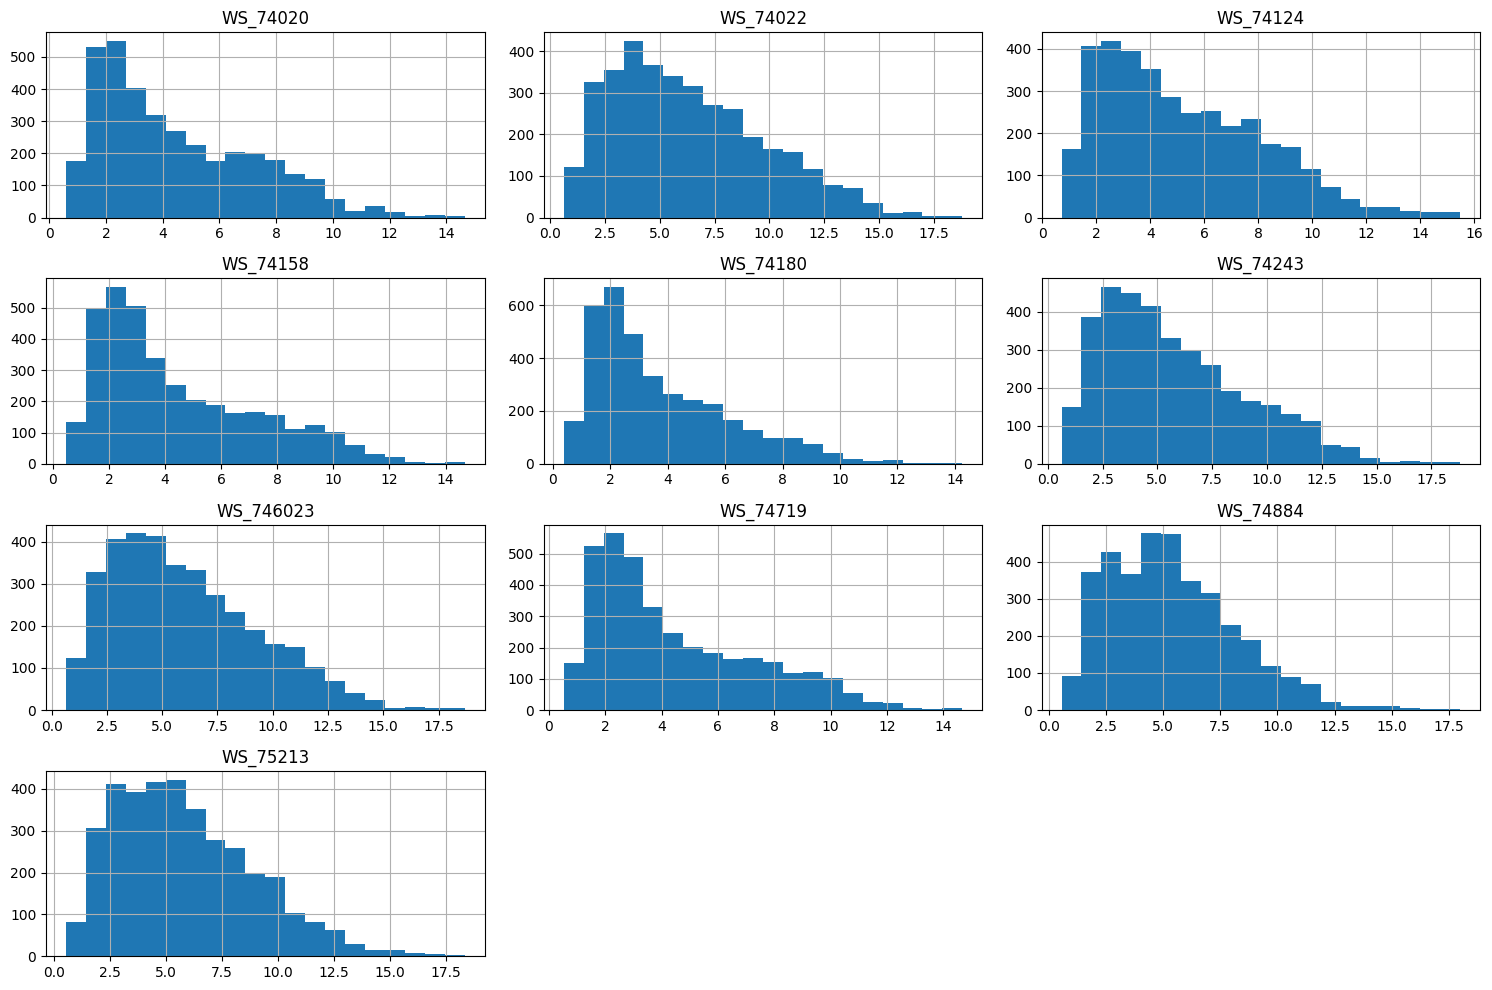

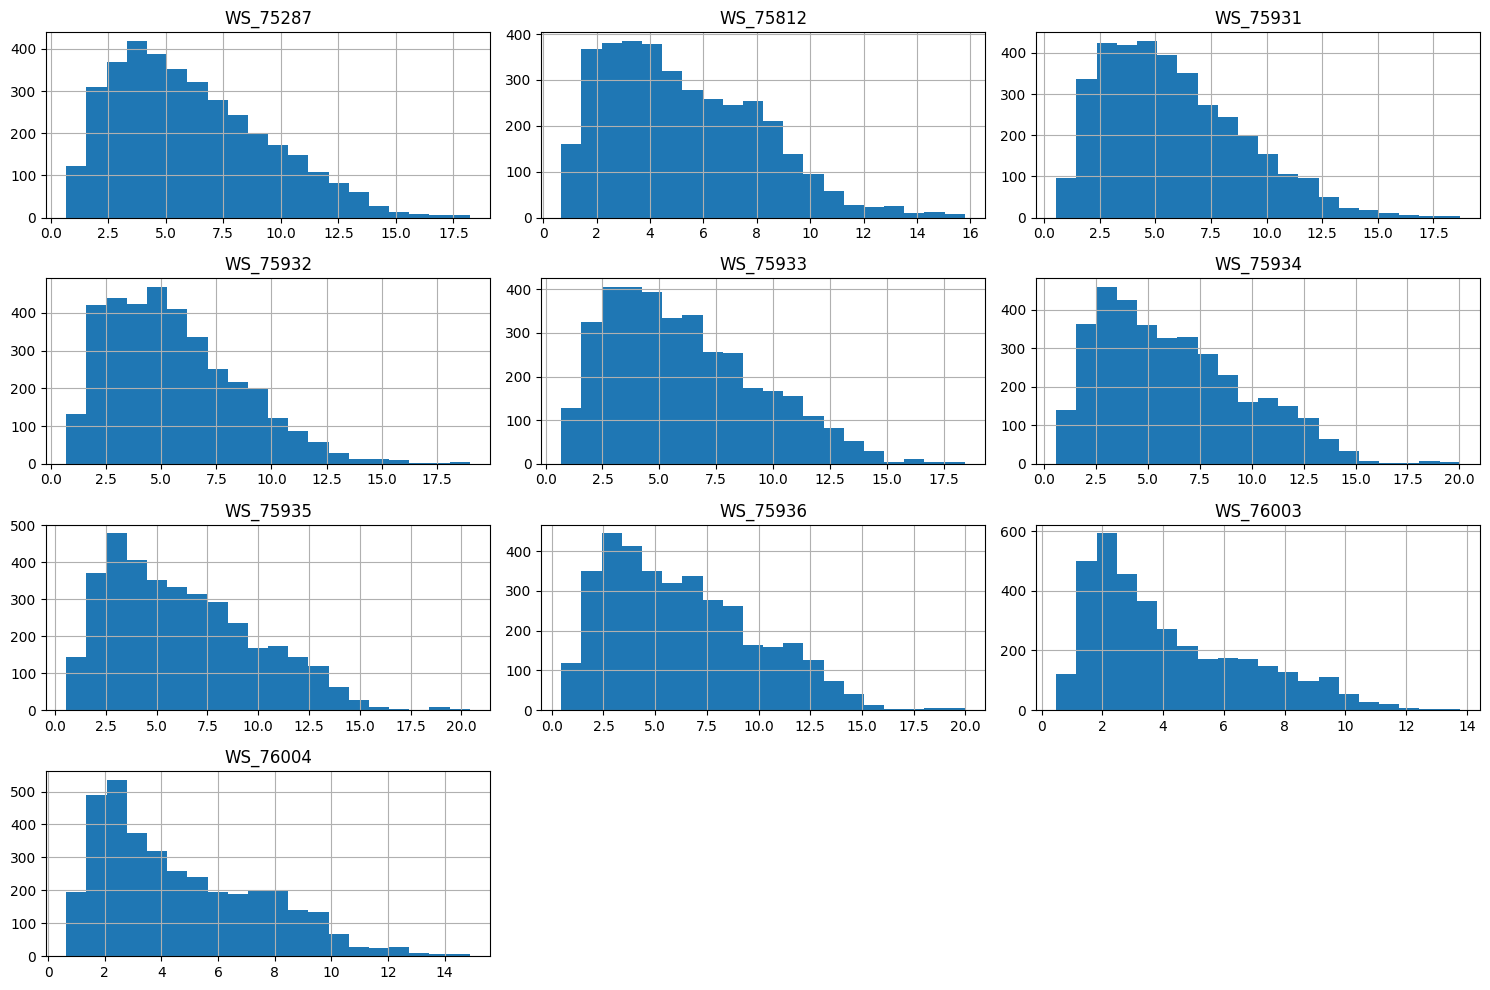

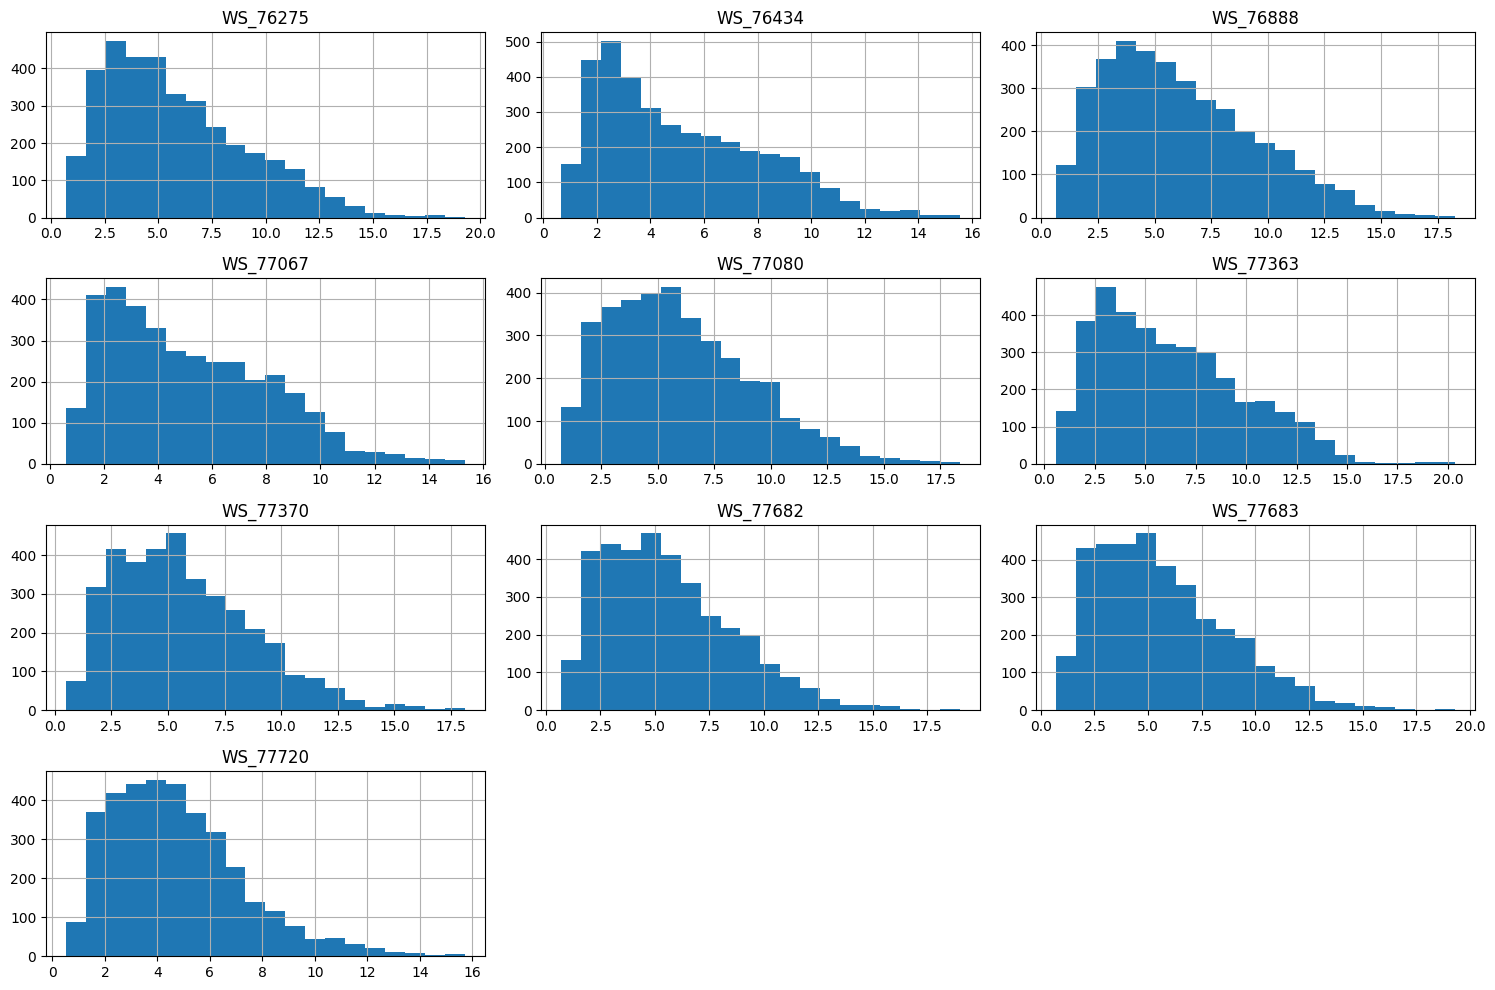

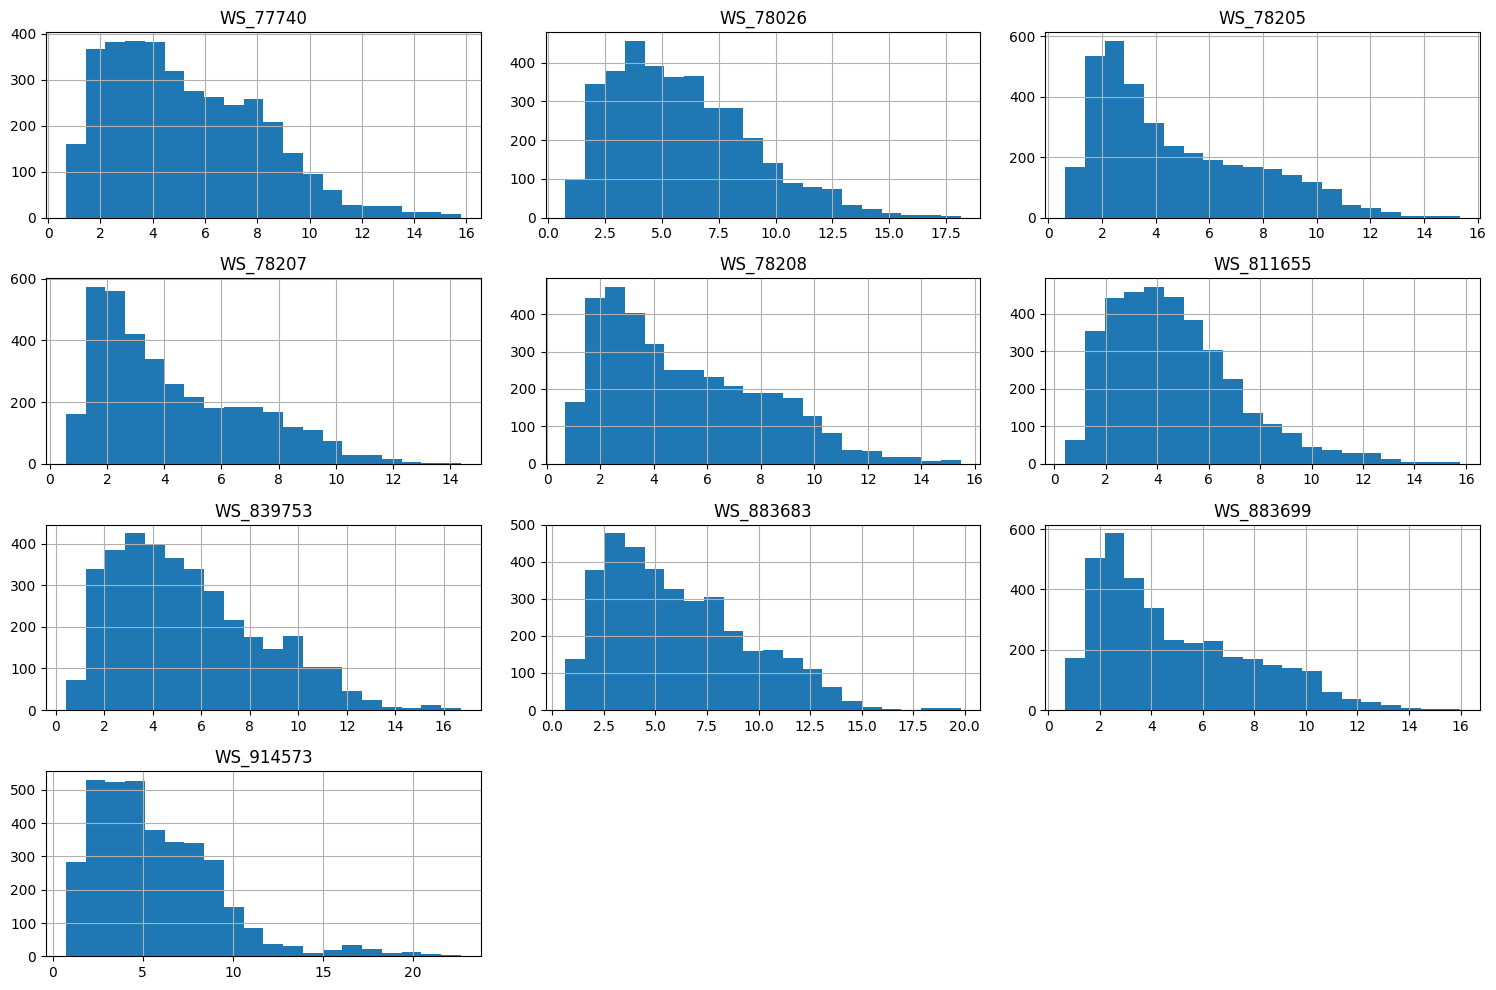

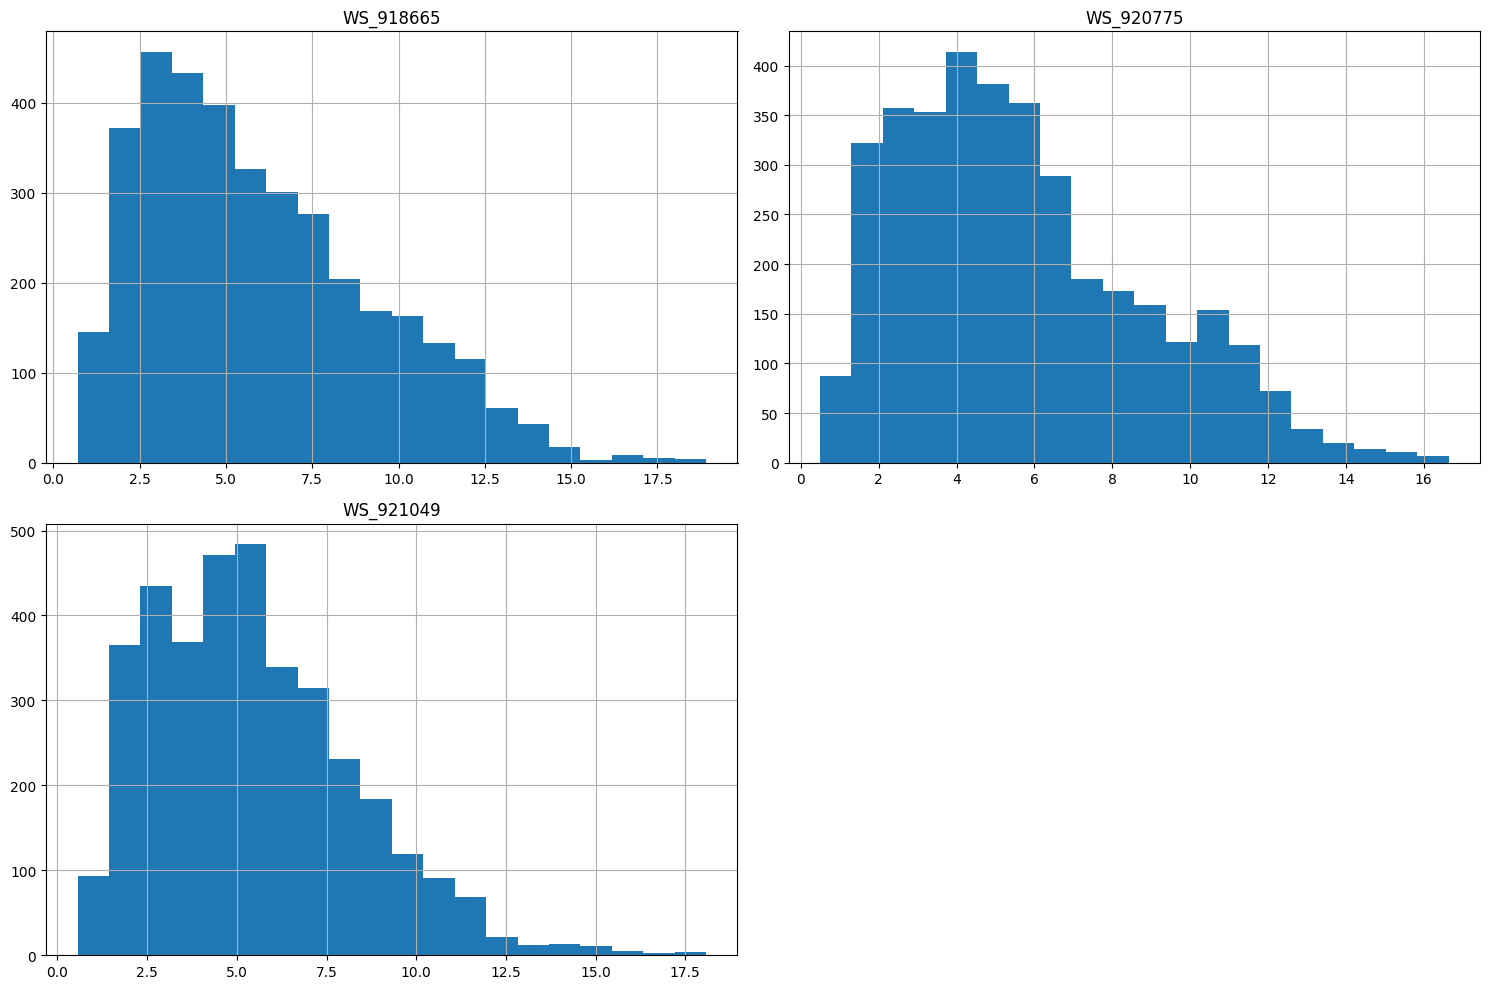

In [21]:
# Plot histograms for features that follow Skewed Distribution.
plot_histograms(data[column_Skewed], batch_size=10)

Above are histograms of features that follow Skewed Distribution.

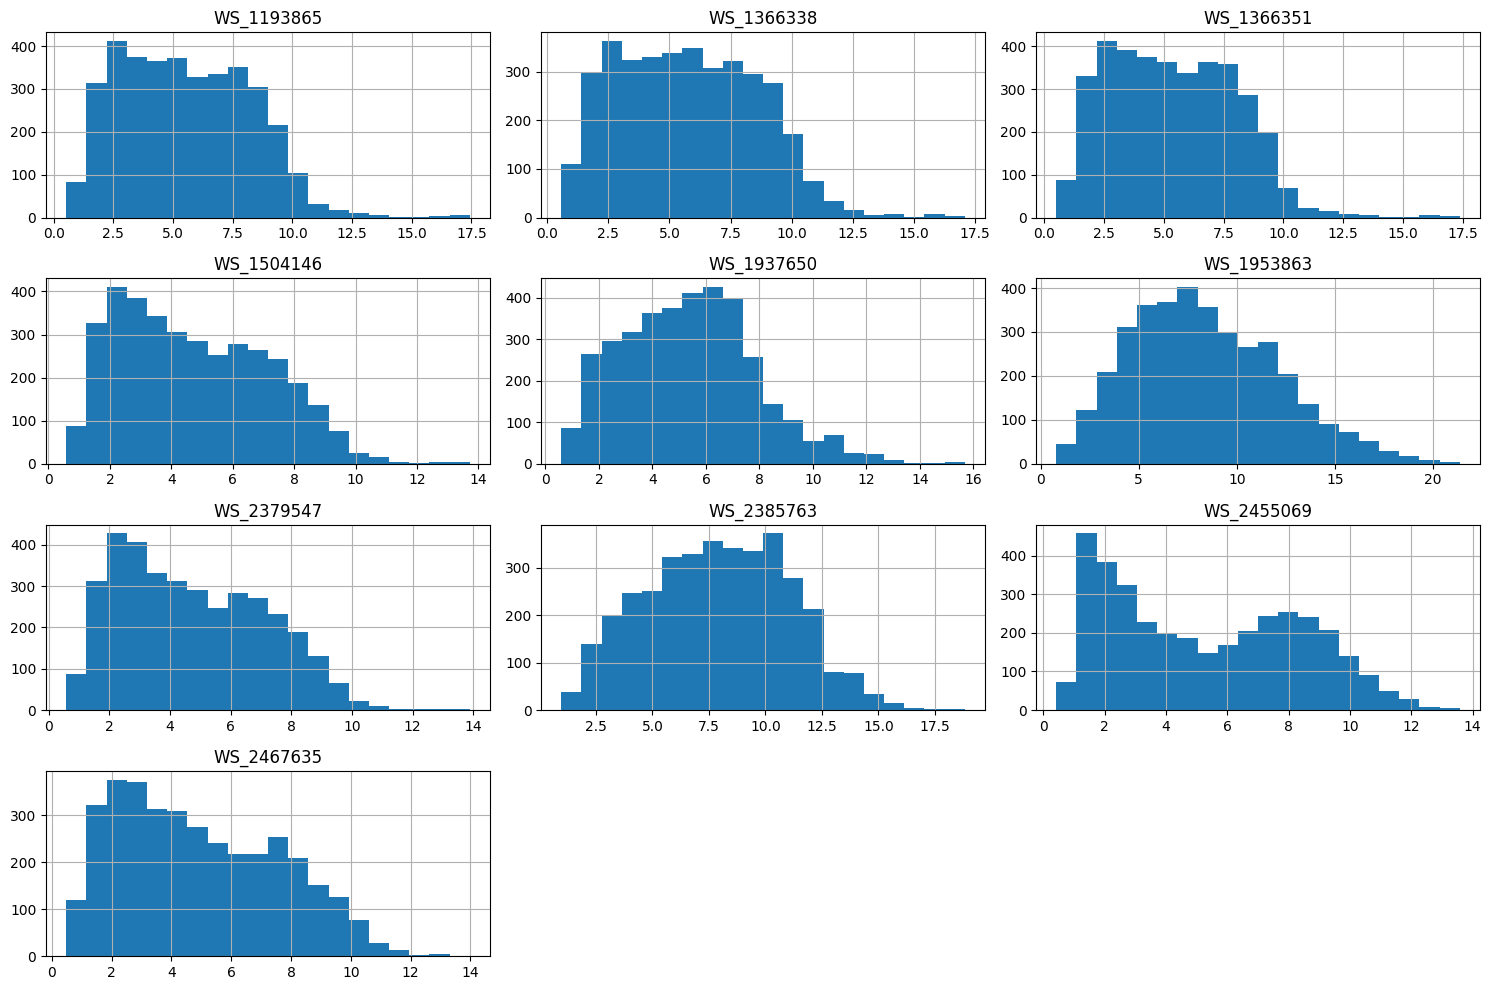

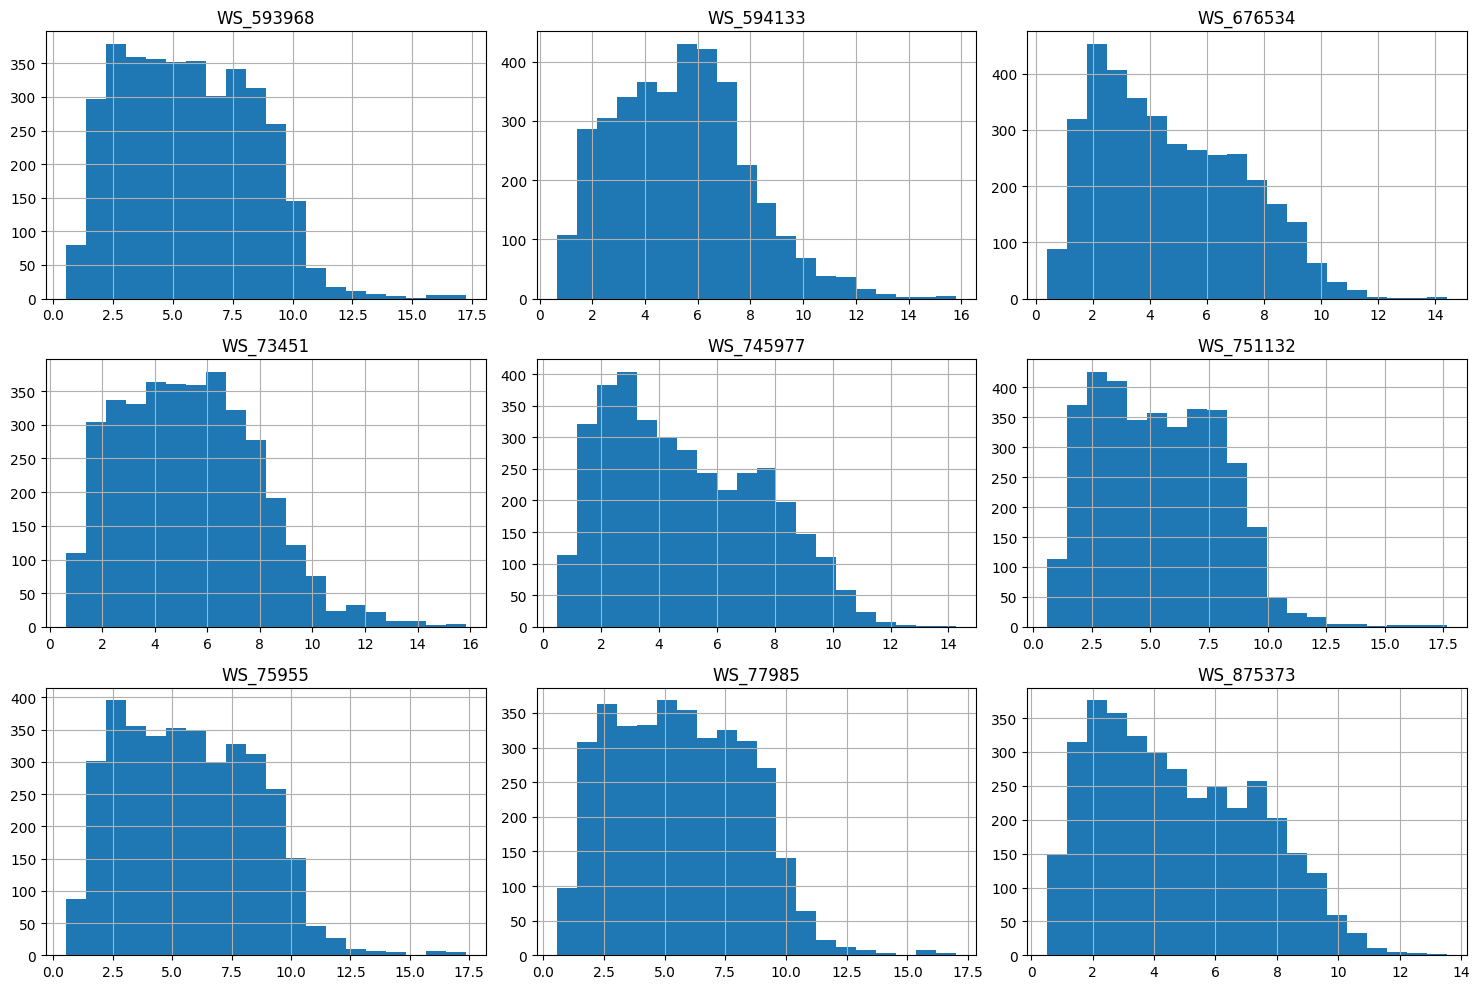

In [22]:
# Plot histograms for features that follow Uniform Distribution.
plot_histograms(data[column_Uniform], batch_size=10)

Above are histograms of features that follow Uniform Distribution.

**Brief summary about raw data:**

**1. Mean and Median Proximity**:
    The mean and median of the features are quite close, indicating a symmetrical distribution of data without significant skewness.

**2. Reasonable Range for Min and Max Values**:
    Both the minimum and maximum values of the features fall within reasonable ranges, suggesting the absence of outliers in the data.

**3. Comparable Standard Deviations**:
    The standard deviations of the features are similar in magnitude, indicating a consistent level of variability across different features.

**4. Distribution Characteristics**:
    From the histograms and numerical summaries of the distributions, it was observed that the wind speed values in most locations are approximately normally distributed.
    In a few locations, the wind speed distribution appears to be nearly uniform.

Now here is the distribution of each row in the dataset:

In [23]:
row_distribution_results = determine_distribution(data.drop('CF', axis=1).T)
row_distribution_results['Distribution Type'].value_counts().reset_index()

,Distribution Type,count
0,Skewed Distribution,2079
1,Uniform Distribution,1430
2,Normal Distribution,126


As we can see, most features follow Skewed Distribution and Uniform Distribution, some features follow Normal Distribution.

Based on these distributions, we extracted the minimum, maximum, and several key percentiles at each time point to represent the characteristics of the wind speed distribution effectively.

In [24]:
def generate_percentiles(data):
    data['MIN_WS'] = data[ws_columns].min(axis=1)
    data['MEDIAN_WS'] = data[ws_columns].median(axis=1)
    data['P5_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 5), axis=1)
    data['P25_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 25), axis=1)
    data['P75_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 75), axis=1)
    data['P95_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 95), axis=1)
    data['MAX_WS'] = data[ws_columns].max(axis=1)
    data['MEAN_WS'] = data[ws_columns].mean(axis=1)
    data['STD_WS'] = data[ws_columns].std(axis=1)
    return data

In [25]:
data = generate_percentiles(data)

In [26]:
predict = generate_percentiles(predict)

# EDA
## Univariate Analysis
- Numerical Variable Distribution
- Categorical Variable Cardinality

In [27]:
def get_new_features(data):
    """
    Extracts new temporal features from the datetime index of a DataFrame.

    Args:
        data (pd.DataFrame): The input DataFrame with a datetime index.

    Returns:
        pd.DataFrame: The DataFrame with new temporal features added.
    """
    # Get information from datetime to help generate seasons etc.
    data['YEAR'] = data.index.year
    data['MONTH'] = data.index.month
    data['DAY'] = data.index.day
    data['HOUR'] = data.index.hour

    # Define seasons
    def get_season(month):
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        elif month in [9, 10, 11]:
            return 'Fall'

    # Define daylight and night based on hour (assuming 6 AM to 6 PM is daylight)
    def get_daylight_night(hour):
        if 6 <= hour < 18:
            return 'Daylight'
        else:
            return 'Night'

    # Define parts of the day
    def get_day_part(hour):
        if 0 <= hour < 6:
            return 'Morning'
        elif 6 <= hour < 12:
            return 'Midday'
        elif 12 <= hour < 18:
            return 'Afternoon'
        else:
            return 'Night'

    # Define weekay and weekend
    mapping1 = {
        0: 'Weekday',
        1: 'Weekday',
        2: 'Weekday',
        3: 'Weekday',
        4: 'Weekday',
        5: 'Weekend',
        6: 'Weekend',
    }

    mapping2 = {
        0: 'Monday',
        1: 'Tuesday',
        2: 'Wednesday',
        3: 'Thursday',
        4: 'Friday',
        5: 'Saturday',
        6: 'Sunday'
    }

    # Generate important categorical features
    data['SEASON'] = data['MONTH'].apply(get_season)
    data['DAY_NIGHT'] = data['HOUR'].apply(get_daylight_night)
    data['DAY_PART'] = data['HOUR'].apply(get_day_part)
    data["IS_WEEKEND"] = data.index.weekday
    data['IS_WEEKEND'] = data['IS_WEEKEND'].apply(lambda x: mapping1[x])
    data['day_of_week'] = data.index.weekday
    data['day_of_week'] = data['day_of_week'].apply(lambda x: mapping2[x])

    return data

In [28]:
# Generate new features, get new dataset
data = get_new_features(data)

In [29]:
# Feature Engineering for predict
predict = get_new_features(predict)

Now I'm going to analyze categorical variable cardinality.

In [30]:
def get_proportion(feature):
    """
    Calculates the proportion of each unique value in the given feature column and returns it as a DataFrame.

    Args:
        feature (pd.Series): The feature column for which to calculate proportions.

    Returns:
        pd.DataFrame: A DataFrame containing the unique values and their corresponding proportions as percentages.
    """
    counts = feature.value_counts(normalize=True)
    percentages = counts * 100
    return percentages.reset_index()

In [31]:
# Calculate the proportion of each season
get_proportion(data['SEASON'])

,SEASON,proportion
0,Fall,59.477304
1,Winter,24.594223
2,Summer,15.928473


The proportion of data points in autumn is higher compared to winter and summer.

So this data is more representative of fall and winter, suggesting that the model's predictions may be less accurate during colder temperatures.

A potential feature to explore is categorizing fall and winter as low temperature seasons, and summer as a high temperature season.

Note: It is important to check whether the test data includes spring.

In [32]:
# Calculate the proportion of each day
get_proportion(data['DAY_NIGHT'])

,DAY_NIGHT,proportion
0,Daylight,50.261348
1,Night,49.738652


This demonstrates that the data is evenly distributed between day and night.

In [33]:
# Calculate the proportion of each day (4 parts)
get_proportion(data['DAY_PART'])

,DAY_PART,proportion
0,Afternoon,25.199450
1,Midday,25.061898
2,Night,24.951857
3,Morning,24.786795


This further demonstrates that the data for parts of a day is evenly distributed.

In [34]:
# Calculate the proportion of each week
get_proportion(data['IS_WEEKEND'])

,IS_WEEKEND,proportion
0,Weekday,72.13205
1,Weekend,27.86795


It was found that 72.13% of the data corresponds to weekdays, while 27.87% corresponds to weekends. Therefore, it can be concluded that the time series data provided is continuous, with no interruptions in the middle.



In [35]:
# Calculate the proportion of each week
get_proportion(data['day_of_week'])

,day_of_week,proportion
0,Friday,14.497937
1,Wednesday,14.470426
2,Tuesday,14.470426
3,Thursday,14.387895
4,Monday,14.305365
5,Saturday,14.030261
6,Sunday,13.837689


This demonstrates that the data is evenly dimstributed among week.

In [36]:
# Calculate the proportion of each month
get_proportion(data['MONTH'])

,MONTH,proportion
0,12,20.412655
1,10,19.889959
2,9,19.807428
3,11,19.779917
4,8,15.928473
5,1,4.181568


This demonstrates that the data is evenly distributed among month.

<Axes: xlabel='count', ylabel='day_of_week'>

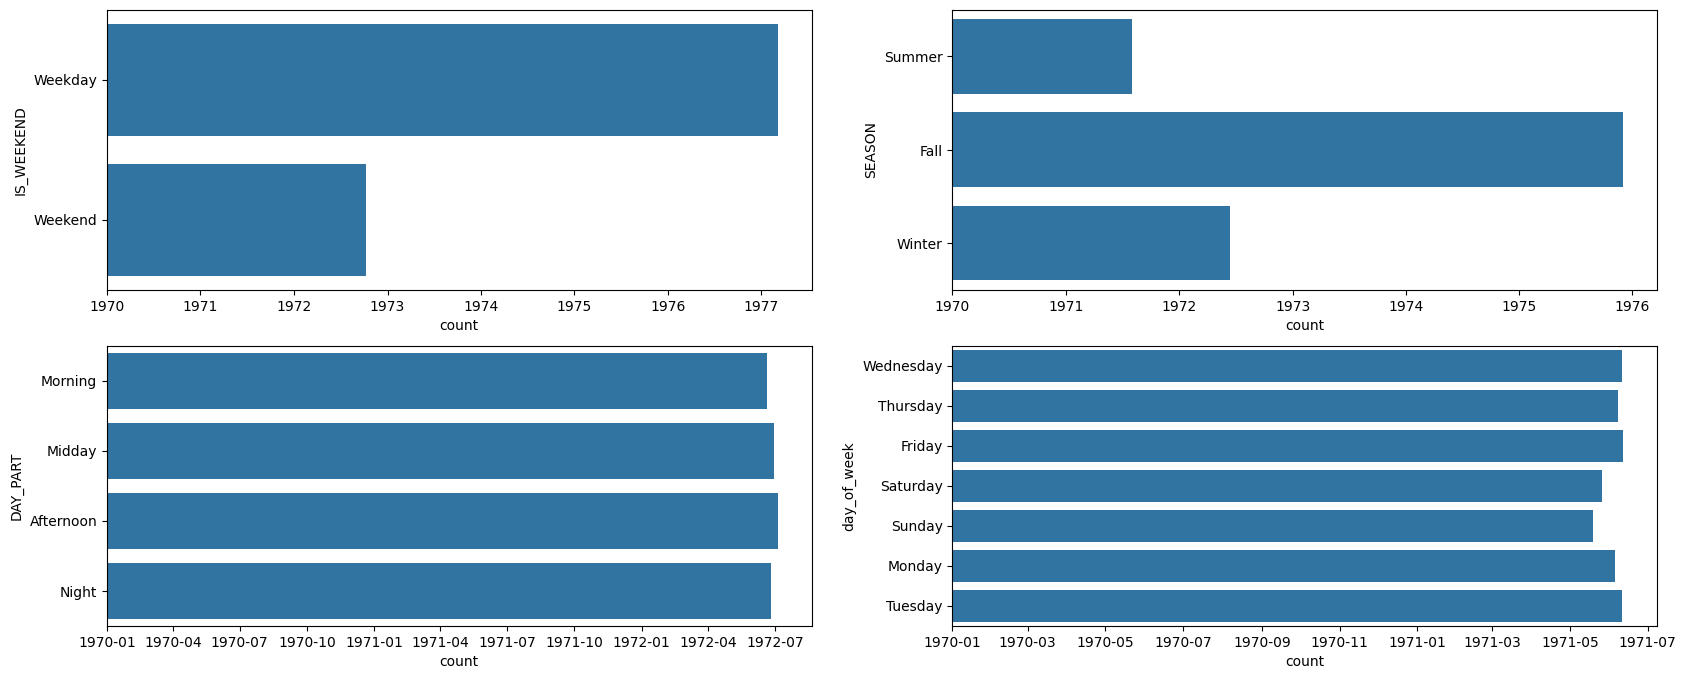

In [37]:
fig=plt.figure(figsize=(20,8))
fig.add_subplot(2,2,1)
sns.countplot(data['IS_WEEKEND'])
fig.add_subplot(2,2,2)
sns.countplot(data['SEASON'])
fig.add_subplot(2,2,3)
# sns.countplot(data['DAY_NIGHT'])
sns.countplot(data['DAY_PART'])
fig.add_subplot(2,2,4)
sns.countplot(data['day_of_week'])

**Univariate Analysis Summary**:
- **Numerical Variable Distribution**
    1. Wind Speed Distribution Across 112 Locations:
        - The wind speed distributions across the 112 different locations approximately follow normal or uniform distributions, with no apparent outliers.
    2. Wind Speed Distribution Across All Time Points:
        - The wind speed distributions across all time points also approximately follow normal or uniform distributions, with no apparent outliers.
    3. Central Tendency:
        - The mean and median of the wind speed data are similar, indicating a symmetric distribution.
    4. Decision:
        - Based on these distributions, we extracted the minimum, maximum, and several key percentiles at each time point to represent the characteristics of the wind speed distribution effectively.


- **Categorical Variable Cardinality**
    1. Categorization Based on Time Points: The data is categorized into various time-related features such as year, month, day, season, weekday, and day/night.
    2. The proportion of data points in autumn is higher compared to winter and summer. The data points are evenly distributed between weekdays and weekends. Measurements taken at different times of the day are also uniformly distributed.

# EDA
## Univariate Analysis
- Numerical Variable Distribution
- Categorical Variable Cardinality

## Bivariate analysis
- Numerical analysis - Correlation

In [38]:
# Prepare Features and Target
ws_sts_columns = [col for col in data.columns if 'WS' in col]
X = data[ws_sts_columns]
y = data['CF']

pearson_results = []
spearman_results = []

# Compute Pearson and Spearman correlations
for column in X.columns:
    if pd.api.types.is_numeric_dtype(X[column]):
        pearson_corr, _ = pearsonr(X[column], y)
        spearman_corr, _ = spearmanr(X[column], y)
        pearson_results.append({'WS_location': column, 'Pearson Correlation': pearson_corr})
        spearman_results.append({'WS_location': column, 'Spearman Correlation': spearman_corr})

pearson_df = pd.DataFrame(pearson_results).sort_values(by='Pearson Correlation', ascending=False)
spearman_df = pd.DataFrame(spearman_results).sort_values(by='Spearman Correlation', ascending=False)

pearson_spearman = pd.merge(pearson_df, spearman_df, on='WS_location')

In [39]:
pearson_spearman

,WS_location,Pearson Correlation,Spearman Correlation
0,MEAN_WS,0.867128,0.884486
1,WS_2503597,0.848757,0.827564
2,P75_WS,0.845775,0.878471
3,MEDIAN_WS,0.842367,0.851489
4,WS_2508550,0.841939,0.840181
5,WS_2508545,0.840002,0.841517
6,WS_75936,0.839991,0.841491
7,WS_75935,0.837190,0.839795
8,WS_75934,0.834120,0.837020
9,WS_77363,0.833789,0.836939


# EDA
## Univariate Analysis
- Numerical Variable Distribution
- Categorical Variable Cardinality

## Bivariate analysis
- Numerical analysis - Correlation
- Categorical analysis

**ANOVA Test**

In [40]:
from scipy.stats import f_oneway, ttest_ind

class1= data[data['SEASON']=='Summer']['CF']
class2= data[data['SEASON']=='Fall']['CF']
class3= data[data['SEASON']=='Winter']['CF']


# Conduct the one-way ANOVA
print('This is the ANOVA-test result of feature SEASON:\n',f_oneway(class1, class2, class3))

This is the ANOVA-test result of feature SEASON:
 F_onewayResult(statistic=83.08876803021315, pvalue=5.202013210703249e-36)


The feature SEASON is correlated with the target value, indicating that the season significantly affects the electricity output.

In [41]:
class1= data[data['day_of_week']=='Monday']['CF']
class2= data[data['day_of_week']=='Tuesday']['CF']
class3= data[data['day_of_week']=='Wednesday']['CF']
class4= data[data['day_of_week']=='Thursday']['CF']
class5= data[data['day_of_week']=='Friday']['CF']
class6= data[data['day_of_week']=='Saturday']['CF']
class7= data[data['day_of_week']=='Sunday']['CF']


# Conduct the one-way ANOVA
print('This is the ANOVA-test result of feature day_of_week:\n',f_oneway(class1, class2, class3, class4, class5, class6, class7))

This is the ANOVA-test result of feature day_of_week:
 F_onewayResult(statistic=8.217475502611896, pvalue=7.45666768797419e-09)


The feature day_of_week is correlated with the target value, indicating that the feature significantly affects the electricity output.

In [42]:
class1= data[data['DAY_PART']=='Morning']['CF']
class2= data[data['DAY_PART']=='Midday']['CF']
class3= data[data['DAY_PART']=='Afternoon']['CF']
class4= data[data['DAY_PART']=='Night']['CF']


# Conduct the one-way ANOVA
print('This is the ANOVA-test result of feature DAY_PART:\n',f_oneway(class1, class2, class3, class4))

This is the ANOVA-test result of feature DAY_PART:
 F_onewayResult(statistic=68.68120772570627, pvalue=3.393868596506757e-43)


The feature DAY_PART is correlated with the target value, indicating that the feature significantly affects the electricity output.

**T-test**

In [43]:
class1= data[data['DAY_NIGHT']=='Night']['CF']
class2= data[data['DAY_NIGHT']=='Daylight']['CF']


# Conduct the t-test
print('This is the T-test result of feature DAY_NIGHT:\n',ttest_ind(class1, class2))

This is the T-test result of feature DAY_NIGHT:
 TtestResult(statistic=13.82232140933804, pvalue=2.172226869557305e-42, df=3633.0)


The feature DAY_NIGHT is correlated with the target value, indicating that the feature significantly affects the electricity output.

In [44]:
class1= data[data['IS_WEEKEND']=='Weekday']['CF']
class2= data[data['IS_WEEKEND']=='Weekend']['CF']


# Conduct the t-test
print('This is the T-test result of feature IS_WEEKEND:\n',ttest_ind(class1, class2))

This is the T-test result of feature IS_WEEKEND:
 TtestResult(statistic=1.3132394681703519, pvalue=0.1891852034969178, df=3633.0)


The feature IS_WEEKEND is not correlated with the target value, indicating that there is no significant difference between this feature.

<Axes: xlabel='day_of_week', ylabel='CF'>

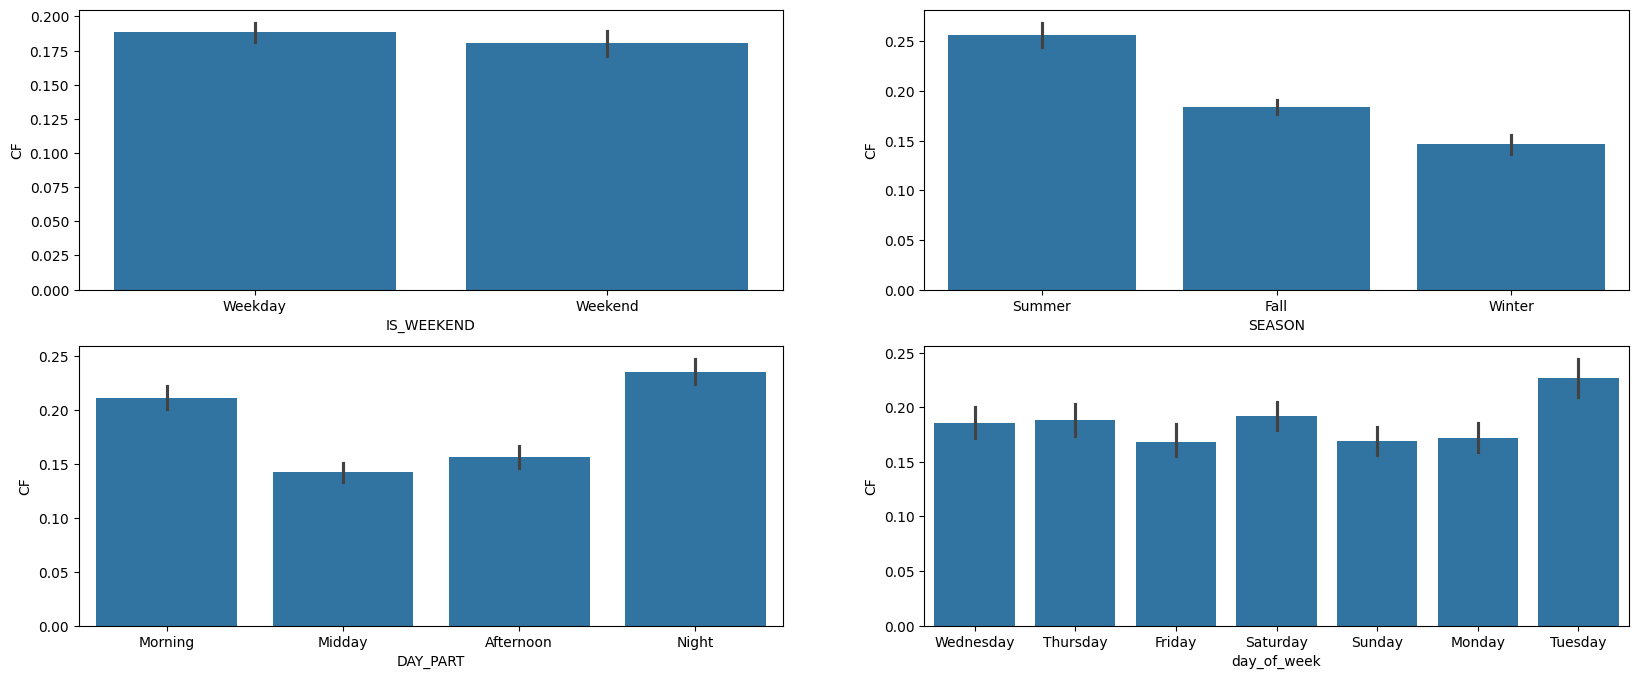

In [45]:
fig=plt.figure(figsize=(20,8))
fig.add_subplot(2,2,1)
sns.barplot(data, x='IS_WEEKEND', y='CF')
fig.add_subplot(2,2,2)
sns.barplot(data, x='SEASON', y='CF')
fig.add_subplot(2,2,3)
# sns.barplot(data, x='DAY_NIGHT', y='CF')
sns.barplot(data, x='DAY_PART', y='CF')
fig.add_subplot(2,2,4)
sns.barplot(data, x='day_of_week', y='CF')

The average value of CF varies across different SEASONS and dayparts.

The bar plot shows numerical values. Now here are distribution plot.

In [46]:
def plot_distribution(data,feature_name, classifications_to_vis):
  """
  Plots the density distribution of the 'CF' feature for different classifications.

  Args:
      data (pd.DataFrame): The dataset containing the features.
      feature_name (str): The column name to group by for classifications (e.g., 'SEASON').
      classifications_to_vis (list): The list of classification values to visualize (e.g., ['Summer', 'Fall']).
  """
  plt.figure(figsize=(10, 3))
  for classification in classifications_to_vis:
      data[data[feature_name] == classification]['CF'].plot(kind='density', label=classification)

  plt.xlim(0, 1.3)
  plt.legend()
  plt.title(f'Distribution of CF for Different Classifications')
  plt.show()

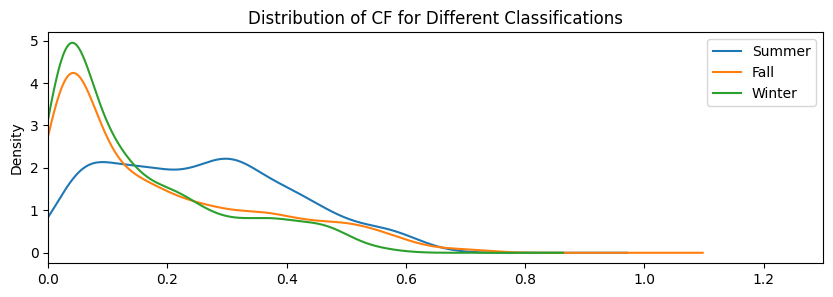

In [47]:
plot_distribution(data, 'SEASON', ['Summer', 'Fall', 'Winter'])

The bar plot only shows numerical values, but the distribution reveals that summer differs significantly from fall and winter.

This observation confirms our earlier hypothesis: we can create a new feature for temperature categorization.

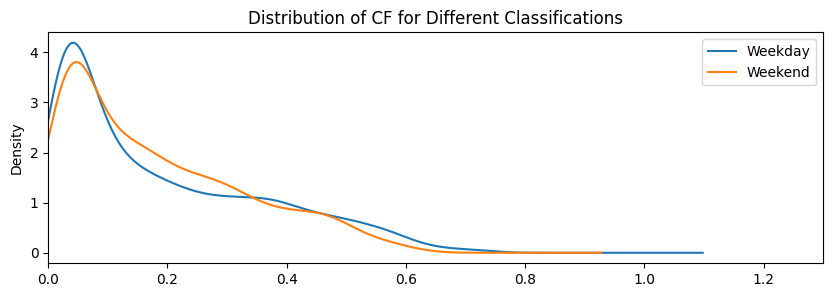

In [48]:
plot_distribution(data, 'IS_WEEKEND', ['Weekday', 'Weekend'])

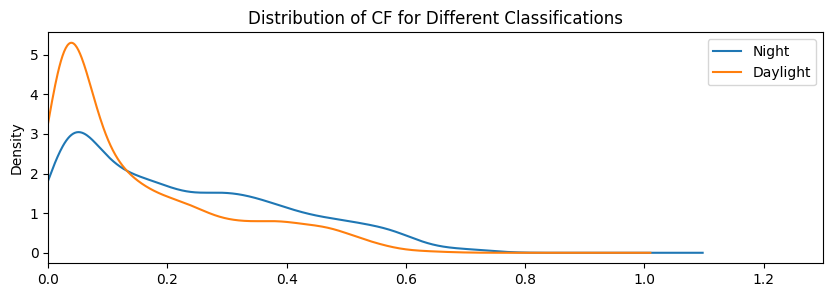

In [49]:
plot_distribution(data, 'DAY_NIGHT', ['Night', 'Daylight'])

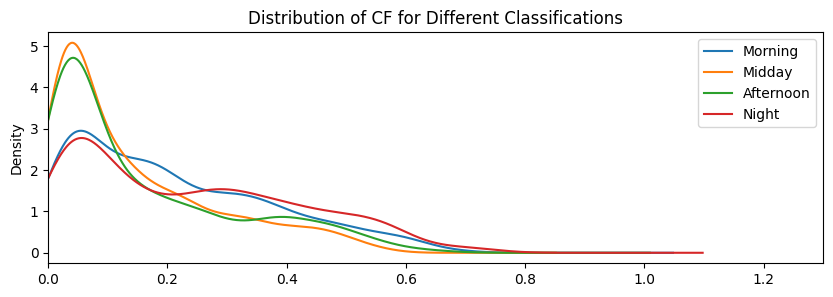

In [50]:
plot_distribution(data, 'DAY_PART', ['Morning', 'Midday', 'Afternoon', 'Night'])

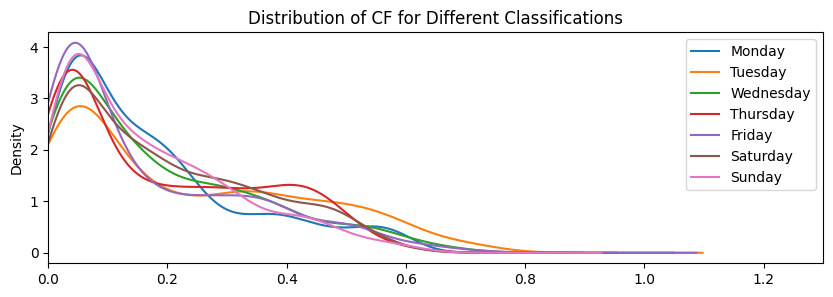

In [51]:
plot_distribution(data, 'day_of_week', ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday'])

Now here is the time series of features and target with dual axes.

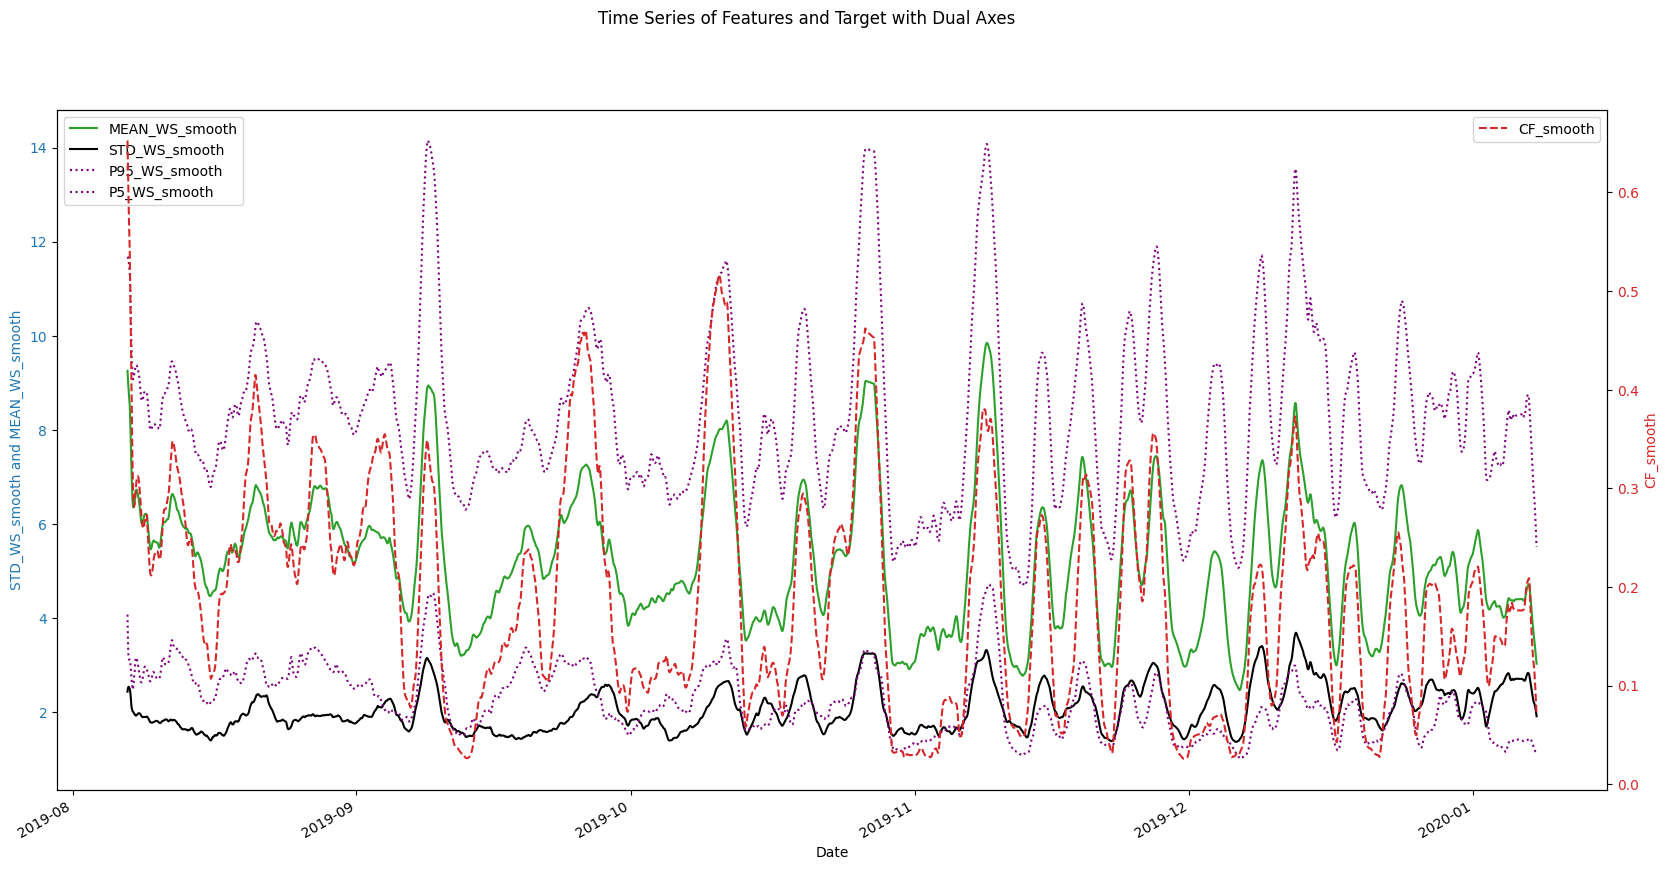

In [52]:
numerical_data = data.select_dtypes(include=[np.number])
numerical_data['CF_smooth'] = numerical_data['CF'].rolling(window=48, min_periods=1).mean()
numerical_data['MEAN_WS_smooth'] = numerical_data['MEAN_WS'].rolling(window=48, min_periods=1).mean()
numerical_data['STD_WS_smooth'] = numerical_data['STD_WS'].rolling(window=48, min_periods=1).mean()
numerical_data['P95_WS_smooth'] = numerical_data['P95_WS'].rolling(window=48, min_periods=1).mean()
numerical_data['P5_WS_smooth'] = numerical_data['P5_WS'].rolling(window=48, min_periods=1).mean()

fig, ax1 = plt.subplots(figsize=(20, 10))

numerical_data['MEAN_WS_smooth'].plot(ax=ax1,label='MEAN_WS_smooth', color='tab:green')
numerical_data['STD_WS_smooth'].plot(ax=ax1,label='STD_WS_smooth', color='black')
numerical_data['P95_WS_smooth'].plot(ax=ax1,label='P95_WS_smooth', color='purple', linestyle=':')
numerical_data['P5_WS_smooth'].plot(ax=ax1,label='P5_WS_smooth', color='purple', linestyle=':')

ax1.set_xlabel('Date')
ax1.set_ylabel('STD_WS_smooth and MEAN_WS_smooth', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()

numerical_data['CF_smooth'].plot(ax=ax2,label='CF_smooth', color='tab:red', linestyle='--')
ax2.set_ylabel('CF_smooth', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.suptitle('Time Series of Features and Target with Dual Axes')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

As we can see, MEAN_WS_smooth, P95_WS_smooth, P5_WS_smooth, and electricity output are strongly correlated.

The analysis reveals that:
- Wind speeds from previous time points influence the current wind speed.
- The current wind speed is strongly correlated with electricity output.

Thus, it can be concluded that wind speeds from past time points indirectly affect the current electricity output.

# Feature Engineering & Part of EDA

In [53]:
def get_data_final(data, correlation):
    ws_columns = [col for col in data.columns if col.startswith('WS_')]
    high_cor_list = correlation[correlation['WS_location'].isin(ws_columns)].iloc[:10]['WS_location'].to_list()
    data_final = data[high_cor_list].copy()

    data_final['MIN_WS'] = data[ws_columns].min(axis=1)
    data_final['MEDIAN_WS'] = data[ws_columns].median(axis=1)
    data_final['P5_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 5), axis=1)
    data_final['P25_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 25), axis=1)
    data_final['P75_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 75), axis=1)
    data_final['P95_WS'] = data[ws_columns].apply(lambda row: np.percentile(row, 95), axis=1)
    data_final['MAX_WS'] = data[ws_columns].max(axis=1)
    data_final['MEAN_WS'] = data[ws_columns].mean(axis=1)
    data_final['STD_WS'] = data[ws_columns].std(axis=1)

    data_final = pd.merge(data_final, data.select_dtypes(include='object'), left_index=True, right_index=True)
    data_final['CF'] = data['CF']
    cols = data_final.columns.tolist()
    new_order = [cols[-1]] + cols[:-1]
    data_final = data_final[new_order]

    return data_final

data_final = get_data_final(data, pearson_spearman)

In [54]:
predict_final = get_data_final(predict, pearson_spearman)

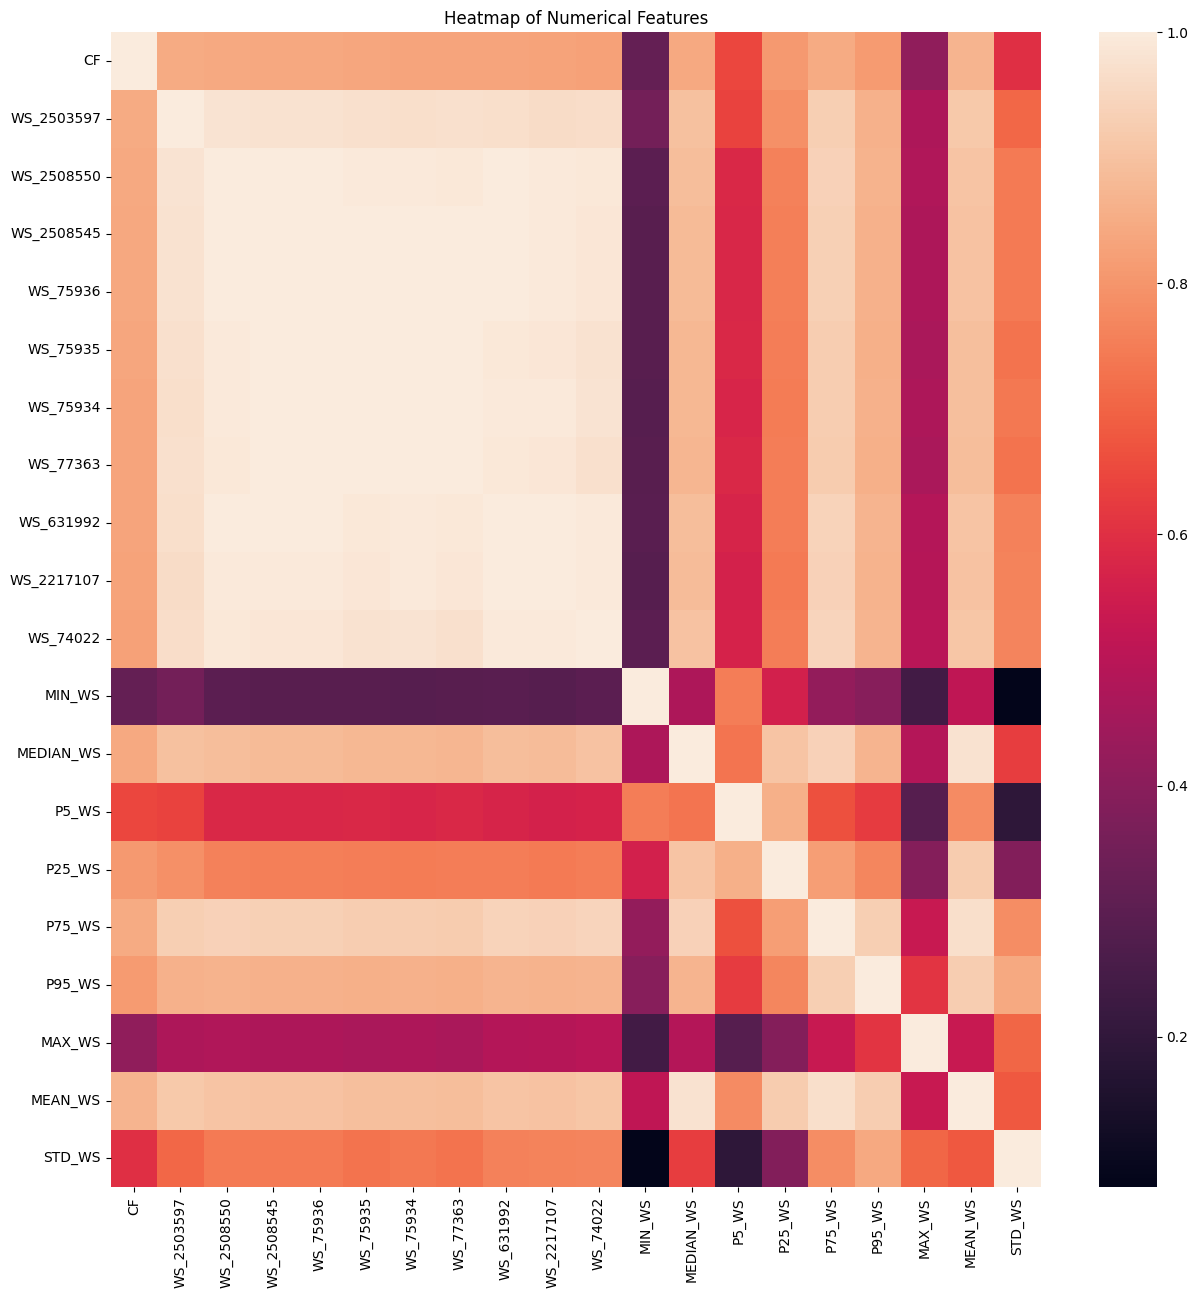

In [55]:
numerical_columns = data_final.select_dtypes(include=[np.number])
plt.figure(figsize=(15,15))
sns.heatmap(numerical_columns.corr())
plt.title('Heatmap of Numerical Features')
plt.show()

## Multivariate Analysis

### Linear Regression - Feature Selection

In [56]:
# Extract categorical features
categorical_features = data.select_dtypes('object').columns

In [57]:
formula= 'CF' + ' ~ C(SEASON) + C(DAY_NIGHT) + C(DAY_PART) + C(IS_WEEKEND) + C(day_of_week) + WS_2503597 + WS_2508550 + WS_2508545 + WS_75936 + WS_75935 + WS_75934 + WS_77363 + WS_631992 + WS_2217107 + WS_74022 + MEAN_WS + MEDIAN_WS + STD_WS + MIN_WS + MAX_WS + P5_WS + P25_WS + P75_WS + P95_WS'
mod = smf.ols(formula, data=data)
res = mod.fit()
print(res.summary())
print('---------------------------------------------------------------------------------------------------')
print('\t')

                            OLS Regression Results                            
Dep. Variable:                     CF   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     569.9
Date:                Tue, 09 Jul 2024   Prob (F-statistic):               0.00
Time:                        05:16:20   Log-Likelihood:                 4566.4
No. Observations:                3635   AIC:                            -9071.
Df Residuals:                    3604   BIC:                            -8879.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

The IS_WEEKEND feature shows no significant differences in its impact on Y in univariate, bivariate, or multivariate analysis. Therefore, this feature has no predictive power and should be discarded.

This also indicates that these **9 key percentilesare** likely to be statistically significant. This could imply that these measures are important in understanding the distribution and variability of the data, influencing decisions or insights derived from the analysis.

### Decision Tree - Feature Selection

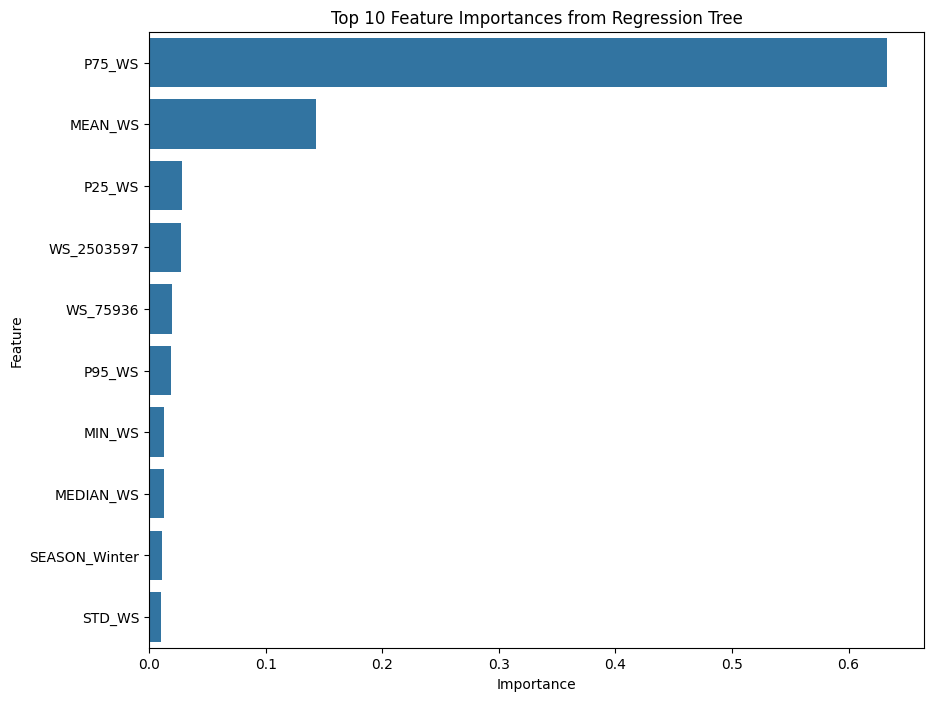

In [58]:
# Prepare Features and Target
X = data_final.drop(columns=['CF'])
y = data_final['CF']
categorical_columns = data_final.select_dtypes('object').columns.to_list()
numerical_columns = X.select_dtypes(include=[np.number]).columns.tolist()

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_columns),
        ('cat', OneHotEncoder(), categorical_columns)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

# Fit the model
pipeline.fit(X, y)
regressor = pipeline.named_steps['regressor']
preprocessor = pipeline.named_steps['preprocessor']

preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)

# Get Feature Importances
encoded_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)
all_feature_names = numerical_columns + encoded_feature_names.tolist()

importances = regressor.feature_importances_

feature_importances = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot only the top 10 features
top_n = 10
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(top_n))
plt.title(f'Top {top_n} Feature Importances from Regression Tree')
plt.show()

Logically, we would expect that the average wind speed around the wind farm would have the most significant impact on electricity generation. However, the feature importance analysis indicates that the 75th percentile wind speed has a greater influence.

In [59]:
# Visualize the regression tree with a larger output size
dot_data = export_graphviz(regressor, out_file=None,
                           feature_names=all_feature_names,
                           filled=True, rounded=True,
                           special_characters=True)
graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render('regression_tree')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.132637 to fit


'regression_tree.png'

I tried to visualize the regression tree, but it's too large to save. However, it showed these 24 features are equally important.

**Brief summary on Multivariate Analysis:**

Based on the coefficients from **OLS regression** and the feature importance from the **decision tree**, I explored both the linear and nonlinear relationships between features and the target value. This analysis allowed me to perform an initial feature selection.

In [60]:
data_final.drop(columns=['IS_WEEKEND'], inplace=True)

In [61]:
predict_final.drop(columns=['IS_WEEKEND'], inplace=True)

The feature engineering process is now complete, resulting in a total of **23 features**:

**Numerical Features (19 total)**:

These include the **10 features with the highest correlation to the target value** and **9 key percentiles** at each time point to represent the characteristics of the wind speed distribution.

- Reason for Selection: These features have a strong relationship with the target variable, indicated by their high correlation values.

**Categorical Features (4 total)**:

These features are: **SEASON, DAY_NIGHT, DAY_PART, day_of_week**.

These features were selected based on bar plots, density plots, ANOVA tests, and t-tests, all of which demonstrated their strong relationship with the target variable.

- Reason for Selection: These features exhibit high predictive power for the target variable.
The selected features are expected to provide robust inputs for the predictive model due to their strong associations with the target value.

Now I start modeling.

# Train Test Split by Time Order

In [62]:
test_split = round(len(data_final)*0.20)
test_split

727

In [63]:
train_data = data_final[:-test_split]
test_data = data_final[-test_split:]

In [64]:
print(train_data.shape)
print(test_data.shape)

(2908, 24)
(727, 24)


## Strategy A - Autogluon

In [65]:
predictor = TabularPredictor(label='CF',
                problem_type= 'regression',
                eval_metric='mean_absolute_error',
                learner_kwargs={'ignored_columns': []}).fit(train_data = train_data,
                                       time_limit=300,
                                       presets="medium_quality_faster_train")

No path specified. Models will be saved in: "AutogluonModels/ag-20240709_051703"
Preset alias specified: 'medium_quality_faster_train' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       10.51 GB / 12.67 GB (83.0%)
Disk Space Avail:   74.12 GB / 107.72 GB (68.8%)
Presets specified: ['medium_quality_faster_train']
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "AutogluonModels/ag-20240709_051703"
Train Data Rows:    2908
Train Data Columns: 23
Label Column:       CF
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    10765.31 MB
	Train Data (Origin

[1000]	valid_set's l1: 0.0326083
[2000]	valid_set's l1: 0.0312811
[3000]	valid_set's l1: 0.0309043
[4000]	valid_set's l1: 0.0307706
[5000]	valid_set's l1: 0.0307226
[6000]	valid_set's l1: 0.0307173
[7000]	valid_set's l1: 0.030722
[8000]	valid_set's l1: 0.0307343


	-0.0307	 = Validation score   (-mean_absolute_error)
	25.41s	 = Training   runtime
	0.93s	 = Validation runtime
Fitting model: LightGBM ... Training model for up to 263.07s of the 263.06s of remaining time.


[1000]	valid_set's l1: 0.0374384
[2000]	valid_set's l1: 0.0372307
[3000]	valid_set's l1: 0.0371928
[4000]	valid_set's l1: 0.0371902


	-0.0372	 = Validation score   (-mean_absolute_error)
	12.69s	 = Training   runtime
	0.32s	 = Validation runtime
Fitting model: RandomForestMSE ... Training model for up to 249.47s of the 249.46s of remaining time.
	-0.0407	 = Validation score   (-mean_absolute_error)
	12.61s	 = Training   runtime
	0.26s	 = Validation runtime
Fitting model: CatBoost ... Training model for up to 236.25s of the 236.25s of remaining time.
	Ran out of time, early stopping on iteration 7831.
	-0.035	 = Validation score   (-mean_absolute_error)
	236.4s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 299.66s of the -0.24s of remaining time.
	Ensemble Weights: {'LightGBMXT': 1.0}
	-0.0307	 = Validation score   (-mean_absolute_error)
	0.08s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 300.4s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 539.3 rows/s (501 batch size)
Tabula

In [66]:
leaderboard_df = pd.DataFrame(predictor.leaderboard(silent=True))
leaderboard_df

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMXT,-0.030707,mean_absolute_error,0.927641,25.413704,0.927641,25.413704,1,True,3
1,WeightedEnsemble_L2,-0.030707,mean_absolute_error,0.928898,25.490354,0.001257,0.076650,2,True,7
2,CatBoost,-0.034980,mean_absolute_error,0.016037,236.401006,0.016037,236.401006,1,True,6
3,LightGBM,-0.037189,mean_absolute_error,0.323673,12.691217,0.323673,12.691217,1,True,4
4,KNeighborsDist,-0.040619,mean_absolute_error,0.039068,0.028404,0.039068,0.028404,1,True,2
5,RandomForestMSE,-0.040713,mean_absolute_error,0.264389,12.607296,0.264389,12.607296,1,True,5
6,KNeighborsUnif,-0.042466,mean_absolute_error,0.081091,9.001541,0.081091,9.001541,1,True,1


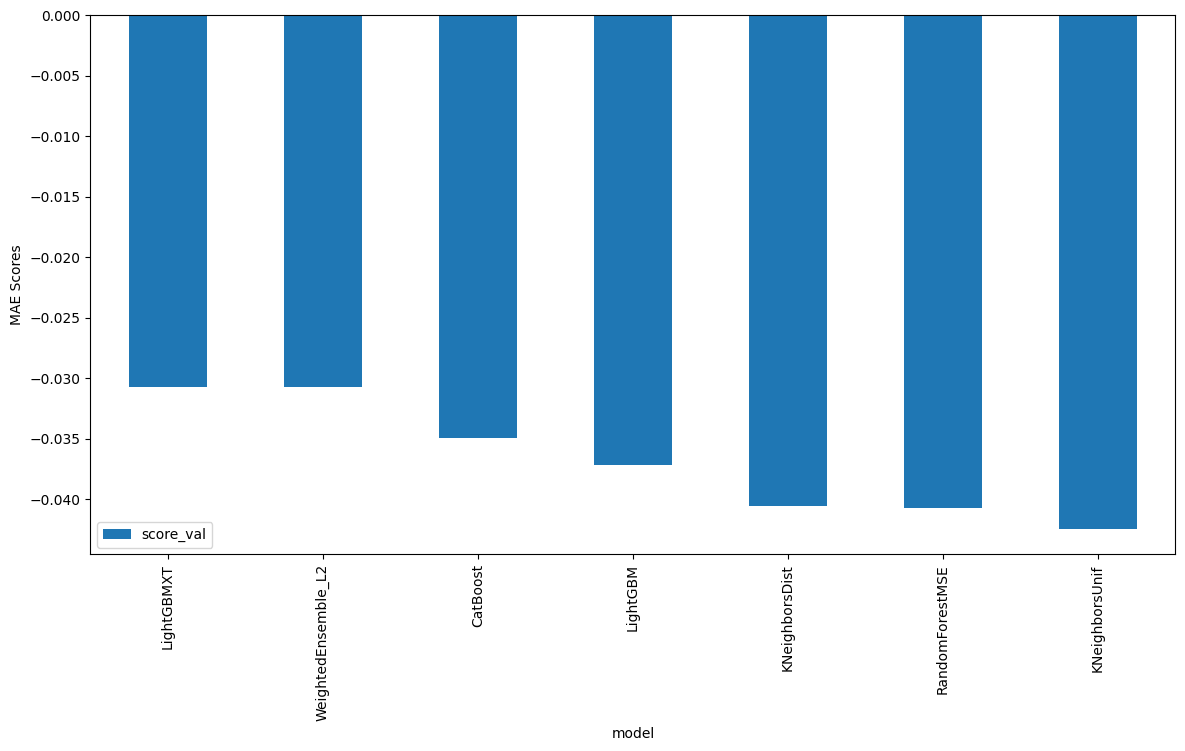

In [67]:
leaderboard_df.plot(kind="bar", x="model", y="score_val", figsize=(14, 7))
plt.ylabel("MAE Scores")
plt.show()

In [68]:
import autogluon.core as space
from autogluon.tabular import TabularPredictor, TabularDataset
import autogluon.common as ag


eval_metric = 'mean_absolute_error'
label = 'CF'
ignored_columns = []   # Ignored columns while training
train_data = train_data                           # 'casual' and 'registered' columns are already dropped/ignored
time_limit = 300                             # 5 minutes -> 60*5 = 300 seconds
presets = "best_quality"


nn_options = {'num_epochs': 5,
              'learning_rate': ag.space.Real(1e-4, 1e-2, default=5e-4, log=True),
                    # learning rate used in training (real-valued hyperparameter searched on log-scale)
              'activation': ag.space.Categorical('relu', 'softrelu', 'tanh'),
                    # activation function used in NN (categorical hyperparameter, default = first entry)
              'dropout_prob': ag.space.Real(0.0, 0.5, default=0.1)}

gbm_options = [{'extra_trees': True,
                'num_boost_round': ag.space.Int(lower=100, upper=500, default=100),
                'num_leaves': ag.space.Int(lower=25, upper=64, default=36),
                'ag_args': {'name_suffix': 'XT'}}, {}, 'GBMLarge']


hyperparameters = {
    'GBM': gbm_options,
    'NN_TORCH': nn_options,
          }

num_trials = 20
search_strategy = 'auto'
scheduler = 'local'
hyperparameter_tune_kwargs = {
    'num_trials': num_trials,
    'scheduler' : scheduler,
    'searcher': search_strategy,
}

predictor_new_hpo = TabularPredictor(label='CF', problem_type='regression', eval_metric='mean_absolute_error',
                                    learner_kwargs={'ignored_columns': ignored_columns}).fit(
                                                                 train_data=train_data,
                                                                 time_limit=time_limit,
                                                                 presets=presets,
                                                                 hyperparameters=hyperparameters,
                                                                 hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
                                                                 refit_full='best'
                                                                 )

No path specified. Models will be saved in: "AutogluonModels/ag-20240709_052204"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       9.92 GB / 12.67 GB (78.3%)
Disk Space Avail:   74.02 GB / 107.72 GB (68.7%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be 

(_dystack pid=52524) ╭──────────────────────────────────────────────────────────╮
(_dystack pid=52524) │ Configuration for experiment     NeuralNetTorch_BAG_L1   │
(_dystack pid=52524) ├──────────────────────────────────────────────────────────┤
(_dystack pid=52524) │ Search algorithm                 SearchGenerator         │
(_dystack pid=52524) │ Scheduler                        FIFOScheduler           │
(_dystack pid=52524) │ Number of trials                 20                      │
(_dystack pid=52524) ╰──────────────────────────────────────────────────────────╯
(_dystack pid=52524) 
(_dystack pid=52524) View detailed results here: /content/AutogluonModels/ag-20240709_052204/ds_sub_fit/sub_fit_ho/models/NeuralNetTorch_BAG_L1


(_dystack pid=52524) Reached timeout of 10.061703229236603 seconds. Stopping all trials.
(_dystack pid=52524) Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
(_dystack pid=52524) You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
(_dystack pid=52524) You can suppress this error by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0).
(_dystack pid=52524) Wrote the latest version of all result files and experiment state to '/content/AutogluonModels/ag-20240709_052204/ds_sub_fit/sub_fit_ho/models/NeuralNetTorch_BAG_L1' in 0.0841s.
(_dystack pid=52524) Failed to fetch metrics for 2 trial(s):
(_dystack pid=52524) - d8fb007b: FileNotFoundError('Could n

(_dystack pid=52524) 


(_dystack pid=52524) 	-0.0392	 = Validation score   (-mean_absolute_error)
(_dystack pid=52524) 	36.84s	 = Training   runtime
(_dystack pid=52524) 	0.14s	 = Validation runtime
(_dystack pid=52524) Fitting model: WeightedEnsemble_L2 ... Training model for up to 67.09s of the -91.4s of remaining time.
(_dystack pid=52524) 	Ensemble Weights: {'LightGBM_BAG_L1/T1': 1.0}
(_dystack pid=52524) 	-0.0347	 = Validation score   (-mean_absolute_error)
(_dystack pid=52524) 	0.09s	 = Training   runtime
(_dystack pid=52524) 	0.0s	 = Validation runtime
(_dystack pid=52524) Fitting 4 L2 models ...
(_dystack pid=52524) Fitting model: WeightedEnsemble_L3 ... Training model for up to 67.09s of the -91.58s of remaining time.
(_dystack pid=52524) 	Ensemble Weights: {'LightGBM_BAG_L1/T1': 1.0}
(_dystack pid=52524) 	-0.0347	 = Validation score   (-mean_absolute_error)
(_dystack pid=52524) 	0.13s	 = Training   runtime
(_dystack pid=52524) 	0.0s	 = Validation runtime
(_dystack pid=52524) AutoGluon training comp

  0%|          | 0/20 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=0.08%)
	Stopping HPO to satisfy time limit...
Fitted model: LightGBMXT_BAG_L1/T1 ...
	-0.0399	 = Validation score   (-mean_absolute_error)
	45.45s	 = Training   runtime
	0.18s	 = Validation runtime
Hyperparameter tuning model: LightGBM_BAG_L1 ... Tuning model for up to 18.81s of the 79.74s of remaining time.


  0%|          | 0/20 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=0.07%)
	Stopping HPO to satisfy time limit...
Fitted model: LightGBM_BAG_L1/T1 ...
	-0.0335	 = Validation score   (-mean_absolute_error)
	62.01s	 = Training   runtime
	0.42s	 = Validation runtime
Hyperparameter tuning model: NeuralNetTorch_BAG_L1 ... Tuning model for up to 18.81s of the 17.6s of remaining time.
2024-07-09 05:26:47,421	INFO tune.py:622 -- [output] This will use the new output engine with verbosity 0. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+----------------------------------------------------------+
| Configuration for experiment     NeuralNetTorch_BAG_L1   |
+----------------------------------------------------------+
| Search algorithm                 SearchGenerator         |
| Scheduler                        FIFOScheduler           |
| Number of trials                 20                      |
+----------------------------------------------------------+

View detailed results here: /content/AutogluonModels/ag-20240709_052204/models/NeuralNetTorch_BAG_L1


2024-07-09 05:27:06,454	INFO timeout.py:54 -- Reached timeout of 18.808895352333785 seconds. Stopping all trials.
2024-07-09 05:27:06,481	INFO tune.py:1016 -- Wrote the latest version of all result files and experiment state to '/content/AutogluonModels/ag-20240709_052204/models/NeuralNetTorch_BAG_L1' in 0.0159s.
2024-07-09 05:27:08,152	WARNING experiment_analysis.py:190 -- Failed to fetch metrics for 2 trial(s):
- 75408543: FileNotFoundError('Could not fetch metrics for 75408543: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20240709_052204/models/NeuralNetTorch_BAG_L1/75408543')
- 9cbd5bad: FileNotFoundError('Could not fetch metrics for 9cbd5bad: both result.json and progress.csv were not found at /content/AutogluonModels/ag-20240709_052204/models/NeuralNetTorch_BAG_L1/9cbd5bad')
No model was trained during hyperparameter tuning NeuralNetTorch_BAG_L1... Skipping this model.
Fitting model: LightGBMLarge_BAG_L1 ... Training model for up to 18.81s of th

	-0.0354	 = Validation score   (-mean_absolute_error)
	41.33s	 = Training   runtime
	0.21s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 125.43s of the -55.65s of remaining time.
	Ensemble Weights: {'LightGBM_BAG_L1/T1': 0.833, 'LightGBMLarge_BAG_L1': 0.167}
	-0.0334	 = Validation score   (-mean_absolute_error)
	0.07s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting 4 L2 models ...
Fitting model: WeightedEnsemble_L3 ... Training model for up to 125.43s of the -55.79s of remaining time.
	Ensemble Weights: {'LightGBM_BAG_L1/T1': 0.833, 'LightGBMLarge_BAG_L1': 0.167}
	-0.0334	 = Validation score   (-mean_absolute_error)
	0.07s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 181.64s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 576.7 rows/s (364 batch size)
Automatically performing refit_full as a post-fit operation (due to `.fit(..., refit_full=True)`
Refitting models vi

In [69]:
leaderboard_df = pd.DataFrame(predictor_new_hpo.leaderboard(silent=True))
leaderboard_df

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-0.033354,mean_absolute_error,0.632196,103.401733,0.001210,0.069840,3,True,5
1,WeightedEnsemble_L2,-0.033354,mean_absolute_error,0.632251,103.397815,0.001266,0.065922,2,True,4
2,LightGBM_BAG_L1/T1,-0.033450,mean_absolute_error,0.423184,62.005868,0.423184,62.005868,1,True,2
3,LightGBMLarge_BAG_L1,-0.035360,mean_absolute_error,0.207802,41.326025,0.207802,41.326025,1,True,3
4,LightGBMXT_BAG_L1/T1,-0.039946,mean_absolute_error,0.181796,45.449072,0.181796,45.449072,1,True,1
5,WeightedEnsemble_L3_FULL,NaN,mean_absolute_error,NaN,6.511748,NaN,0.069840,3,True,8
6,LightGBM_BAG_L1/T1_FULL,NaN,mean_absolute_error,NaN,3.589064,NaN,3.589064,1,True,6
7,LightGBMLarge_BAG_L1_FULL,NaN,mean_absolute_error,NaN,2.852844,NaN,2.852844,1,True,7


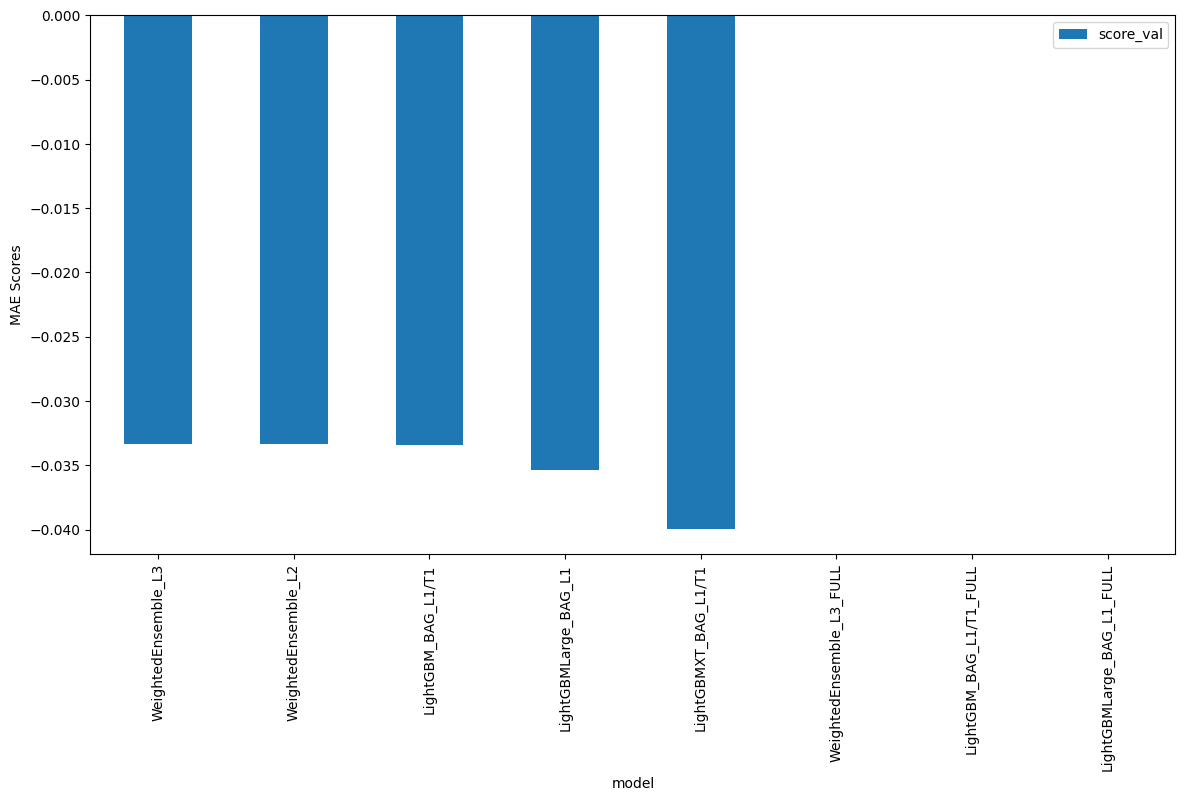

In [70]:
leaderboard_df.plot(kind="bar", x="model", y="score_val", figsize=(14, 7))
plt.ylabel("MAE Scores")
plt.show()

In [71]:
predictions = predictor_new_hpo.predict(test_data)
predictions.reset_index()

,DATETIME,CF
0,2019-12-07 23:00:00,0.250315
1,2019-12-08 00:00:00,0.341024
2,2019-12-08 01:00:00,0.341859
3,2019-12-08 02:00:00,0.336432
4,2019-12-08 03:00:00,0.337521
...,...,...
722,2020-01-07 19:00:00,0.014758
723,2020-01-07 20:00:00,0.009465
724,2020-01-07 21:00:00,0.008519
725,2020-01-07 22:00:00,0.012061


In [72]:
mean_absolute_error(test_data['CF'], predictions)

0.04660373647085374

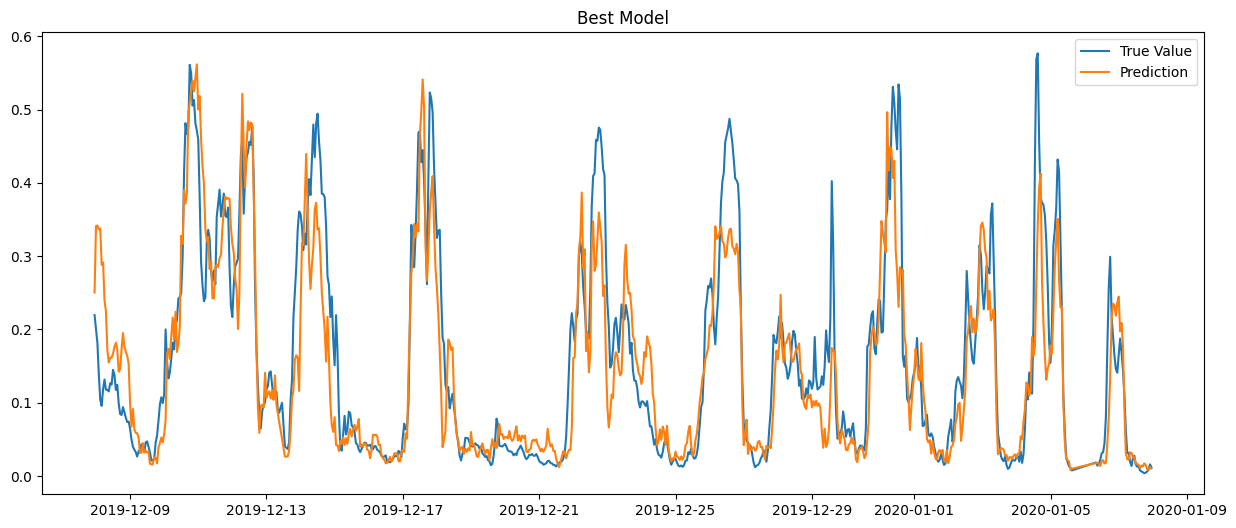

In [73]:
plt.figure(figsize=(15,6))
plt.title('Best Model')
plt.plot(test_data['CF'], label='True Value')
plt.plot(predictions, label='Prediction')
plt.legend()
plt.show()

In [74]:
best_model = predictor_new_hpo.get_model_best()
print("Best model:", best_model)

Best model: WeightedEnsemble_L2


<ipython-input-74-2f3c693cf1ae>:1: DeprecationWarning: `get_model_best` has been deprecated and will be removed in version 1.2. Please use `model_best` instead. This will raise an error in the future!
  best_model = predictor_new_hpo.get_model_best()


In [75]:
predictions_best_model = predictor_new_hpo.predict(test_data, model=best_model)

In [76]:
mean_absolute_error(test_data['CF'], predictions_best_model)

0.04660373647085374

In [77]:
feature_importance = predictor_new_hpo.feature_importance(train_data)
print(feature_importance)

Computing feature importance via permutation shuffling for 23 features using 2908 rows with 5 shuffle sets...
	395.37s	= Expected runtime (79.07s per shuffle set)
	366.14s	= Actual runtime (Completed 5 of 5 shuffle sets)


             importance    stddev       p_value  n  p99_high   p99_low
P75_WS         0.063110  0.000996  7.438288e-09  5  0.065160  0.061059
MEAN_WS        0.032243  0.000506  7.290037e-09  5  0.033285  0.031201
P95_WS         0.021754  0.000333  6.548596e-09  5  0.022439  0.021070
P25_WS         0.019794  0.000348  1.151384e-08  5  0.020511  0.019076
WS_2503597     0.014438  0.000417  8.313793e-08  5  0.015296  0.013580
day_of_week    0.012539  0.000230  1.359887e-08  5  0.013012  0.012065
WS_2508550     0.011328  0.000196  1.066300e-08  5  0.011731  0.010925
MAX_WS         0.010864  0.000162  5.975581e-09  5  0.011198  0.010529
MIN_WS         0.010526  0.000099  9.232573e-10  5  0.010729  0.010323
MEDIAN_WS      0.010064  0.000106  1.495688e-09  5  0.010283  0.009845
WS_74022       0.008740  0.000213  4.212252e-08  5  0.009179  0.008302
STD_WS         0.007683  0.000284  2.245567e-07  5  0.008268  0.007097
SEASON         0.006388  0.000276  4.146021e-07  5  0.006956  0.005821
WS_250

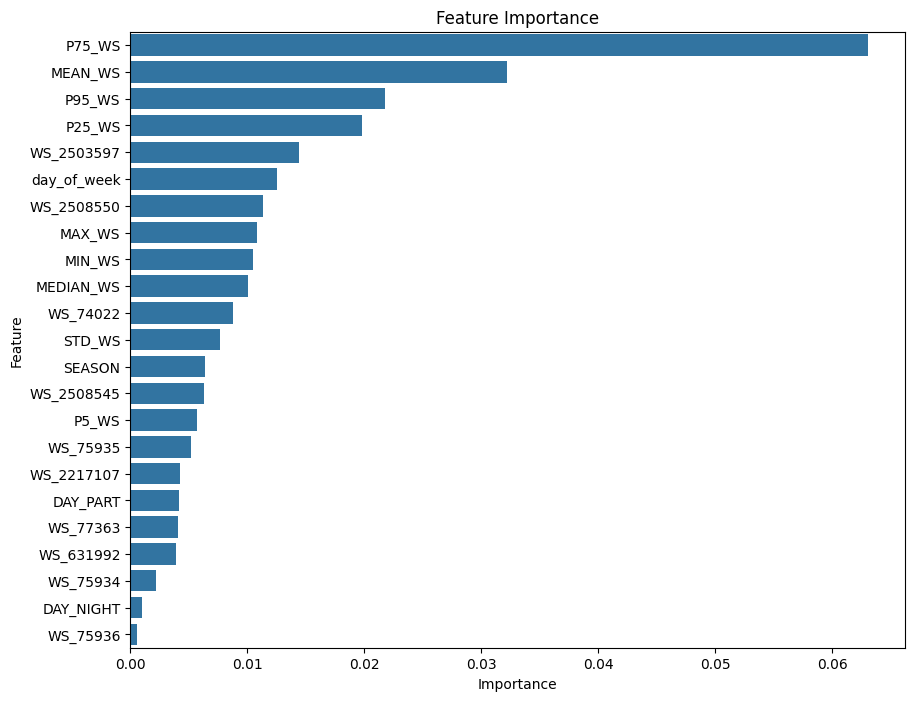

In [78]:
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importance['importance'], y=feature_importance.index)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [79]:
predictions_predict = predictor_new_hpo.predict(predict_final)

In [80]:
final_result = predictions_predict.reset_index()
final_result.to_csv('final1.csv')
final_result

,DATETIME,CF
0,2020-01-09 00:00:00,0.016657
1,2020-01-09 01:00:00,0.023660
2,2020-01-09 02:00:00,0.030831
3,2020-01-09 03:00:00,0.033110
4,2020-01-09 04:00:00,0.044160
5,2020-01-09 05:00:00,0.035115
6,2020-01-09 06:00:00,0.062507
7,2020-01-09 07:00:00,0.108256
8,2020-01-09 08:00:00,0.128102
9,2020-01-09 09:00:00,0.104657


# LSTM

## Model Training

## Feature Engineering

Add some more new features in the third version.

**New Feature**:
- Three features with the **highest correlation** to the target value;
- Two categorical features: **SEASON, DAY_NIGHT**

In [83]:
def get_data_final_LSTM(data, correlation, rolling_window=1):
  ws_columns = [col for col in data.columns if col.startswith('WS_')]
  high_cor_list = correlation[correlation['WS_location'].isin(ws_columns)].iloc[:3]['WS_location'].to_list()
  data_final = pd.DataFrame()
  data_final[high_cor_list[0]] = data[high_cor_list[0]].shift().rolling(rolling_window, min_periods=1).mean()
  data_final[high_cor_list[1]] = data[high_cor_list[1]].shift().rolling(rolling_window, min_periods=1).mean()
  data_final[high_cor_list[2]] = data[high_cor_list[2]].shift().rolling(rolling_window, min_periods=1).mean()

  data_final['MEAN_WS_ROLLING_AVG'] = data['MEAN_WS'].shift().rolling(rolling_window, min_periods=1).mean()
  data_final['STD_WS_ROLLING_AVG'] = data['STD_WS'].shift().rolling(rolling_window, min_periods=1).mean()
  data_final['P5_WS_ROLLING_AVG'] = data['P5_WS'].shift().rolling(rolling_window, min_periods=1).mean()
  data_final['P95_WS_ROLLING_AVG'] = data['P95_WS'].shift().rolling(rolling_window, min_periods=1).mean()

  categorical_columns = ['SEASON', 'DAY_NIGHT']
  temp = data[categorical_columns].copy()
  encoder = OneHotEncoder(sparse_output=False)
  encoded_data = encoder.fit_transform(temp)
  encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_columns))
  encoded_df.index = data_final.index
  data_final = pd.merge(data_final, encoded_df, left_index=True, right_index=True)

  data_final['CF'] = data['CF']

  data_final = data_final.dropna()
  return data_final

dataB = get_data_final_LSTM(data, pearson_spearman)

In [84]:
dataB

,WS_2503597,WS_2508550,WS_2508545,MEAN_WS_ROLLING_AVG,STD_WS_ROLLING_AVG,P5_WS_ROLLING_AVG,P95_WS_ROLLING_AVG,SEASON_Fall,SEASON_Summer,SEASON_Winter,DAY_NIGHT_Daylight,DAY_NIGHT_Night,CF
DATETIME,,,,,,,,,,,,,
2019-08-07 01:00:00,11.75,11.92,11.55,9.254286,2.437052,4.0750,11.6790,0.0,1.0,0.0,0.0,1.0,0.605852
2019-08-07 02:00:00,11.67,11.99,11.73,8.919286,2.564288,3.1000,11.6590,0.0,1.0,0.0,0.0,1.0,0.564094
2019-08-07 03:00:00,11.37,11.90,11.73,8.690000,2.583354,2.6310,11.5625,0.0,1.0,0.0,0.0,1.0,0.532721
2019-08-07 04:00:00,11.25,11.84,11.74,8.560893,2.585717,2.7930,11.5725,0.0,1.0,0.0,0.0,1.0,0.495608
2019-08-07 06:00:00,10.77,11.35,11.22,8.165714,2.487341,2.9725,11.0715,0.0,1.0,0.0,1.0,0.0,0.384439
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-07 19:00:00,1.00,0.95,1.26,2.037500,1.284776,0.8500,3.4040,0.0,0.0,1.0,0.0,1.0,0.004494
2020-01-07 20:00:00,0.90,0.96,1.34,1.923393,1.208378,1.0300,3.0835,0.0,0.0,1.0,0.0,1.0,0.006143
2020-01-07 21:00:00,0.84,0.58,0.90,1.789732,1.197688,0.8665,3.0785,0.0,0.0,1.0,0.0,1.0,0.008399


## Train Test Split by Time Order

In [85]:
test_split=round(len(dataB)*0.20)
test_split

727

In [86]:
df_for_training=dataB[:-test_split]
df_for_testing=dataB[-test_split:]
print(df_for_training.shape)
print(df_for_testing.shape)

(2907, 13)
(727, 13)


## Data Scaling

In [87]:
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled = scaler.transform(df_for_testing)
df_for_training_scaled

array([[0.55924641, 0.58772379, 0.56813525, ..., 0.        , 1.        ,
        0.82554733],
       [0.55528012, 0.59130435, 0.57735656, ..., 0.        , 1.        ,
        0.76831153],
       [0.54040654, 0.58670077, 0.57735656, ..., 0.        , 1.        ,
        0.72530971],
       ...,
       [0.56817055, 0.63938619, 0.62653689, ..., 0.        , 1.        ,
        0.3310033 ],
       [0.59742191, 0.65933504, 0.6454918 , ..., 0.        , 1.        ,
        0.31736914],
       [0.5805652 , 0.6455243 , 0.62295082, ..., 0.        , 1.        ,
        0.29879807]])

## Training Data Preparation for LSTM

In [88]:
def createXY(dataset,n_past):
    """
    Create input sequences and target values for LSTM training.

    Args:
        dataset (np.ndarray): The scaled dataset from which to create sequences.
        n_past (int): The number of past time steps to use as input features.

    Returns:
        tuple: Two numpy arrays, dataX and dataY, where dataX contains input sequences and dataY contains target values.
    """
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            # dataY.append(dataset[i,0])
            dataY.append(dataset[i,-1]) # Corrected
    return np.array(dataX),np.array(dataY)

trainX,trainY=createXY(df_for_training_scaled, 30)
testX,testY=createXY(df_for_testing_scaled, 30)


In [89]:
print("trainX Shape-- ", trainX.shape)
print("trainY Shape-- ", trainY.shape)

trainX Shape--  (2877, 30, 13)
trainY Shape--  (2877,)


In [90]:
print("testX Shape-- ", testX.shape)
print("testY Shape-- ", testY.shape)

testX Shape--  (697, 30, 13)
testY Shape--  (697,)


In [91]:
print(testX.round(3))

[[[0.565 0.635 0.61  ... 0.    1.    0.296]
  [0.562 0.632 0.609 ... 0.    1.    0.27 ]
  [0.52  0.606 0.577 ... 0.    1.    0.244]
  ...
  [0.273 0.304 0.294 ... 0.    1.    0.05 ]
  [0.265 0.3   0.289 ... 0.    1.    0.044]
  [0.248 0.286 0.277 ... 0.    1.    0.04 ]]

 [[0.562 0.632 0.609 ... 0.    1.    0.27 ]
  [0.52  0.606 0.577 ... 0.    1.    0.244]
  [0.534 0.594 0.563 ... 0.    1.    0.185]
  ...
  [0.265 0.3   0.289 ... 0.    1.    0.044]
  [0.248 0.286 0.277 ... 0.    1.    0.04 ]
  [0.255 0.285 0.276 ... 0.    1.    0.031]]

 [[0.52  0.606 0.577 ... 0.    1.    0.244]
  [0.534 0.594 0.563 ... 0.    1.    0.185]
  [0.498 0.584 0.559 ... 0.    1.    0.137]
  ...
  [0.248 0.286 0.277 ... 0.    1.    0.04 ]
  [0.255 0.285 0.276 ... 0.    1.    0.031]
  [0.238 0.276 0.269 ... 1.    0.    0.041]]

 ...

 [[0.06  0.067 0.067 ... 1.    0.    0.107]
  [0.066 0.096 0.092 ... 1.    0.    0.236]
  [0.104 0.207 0.202 ... 1.    0.    0.349]
  ...
  [0.041 0.058 0.066 ... 0.    1.    0. 

In [92]:
# # To make the package version consistant if I have more time, it's better to use container
# !pip install keras==2.12.0
# !pip install tensorflow==2.10.1

In [93]:
# !pip install protobuf==3.20.*

## LSTM Model Configuration

In [94]:
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(50, return_sequences=True,input_shape=(30,13)))
    grid_model.add(LSTM(50))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))
    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model

grid_model = KerasRegressor(build_fn=build_model, verbose=1, validation_data=(testX,testY))

parameters = {'batch_size' : [16, 32],
        'epochs' : [8, 10],
        'optimizer' : ['adam', 'Adadelta']
        }

grid_search  = GridSearchCV(
                estimator = grid_model,
                param_grid = parameters,
                cv = 2
               )

<ipython-input-94-d8b98283743c>:10: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model = KerasRegressor(build_fn=build_model, verbose=1, validation_data=(testX,testY))


## Model Training with Grid Search

In [95]:
grid_search = grid_search.fit(trainX, trainY)

Epoch 1/8
90/90 [==============================] - 10s 53ms/step - loss: 0.0262 - val_loss: 0.0177
Epoch 2/8
90/90 [==============================] - 4s 50ms/step - loss: 0.0125 - val_loss: 0.0132
Epoch 3/8
90/90 [==============================] - 5s 55ms/step - loss: 0.0108 - val_loss: 0.0106
Epoch 4/8
90/90 [==============================] - 4s 41ms/step - loss: 0.0086 - val_loss: 0.0100
Epoch 5/8
90/90 [==============================] - 4s 41ms/step - loss: 0.0080 - val_loss: 0.0115
Epoch 6/8
90/90 [==============================] - 5s 59ms/step - loss: 0.0067 - val_loss: 0.0094
Epoch 7/8
90/90 [==============================] - 5s 54ms/step - loss: 0.0062 - val_loss: 0.0077
Epoch 8/8
90/90 [==============================] - 1s 14ms/step - loss: 0.0095
Epoch 1/8
90/90 [==============================] - 17s 140ms/step - loss: 0.0331 - val_loss: 0.0349
Epoch 2/8
90/90 [==============================] - 5s 55ms/step - loss: 0.0170 - val_loss: 0.0234
Epoch 3/8
90/90 [===================

In [96]:
grid_search.best_params_

{'batch_size': 16, 'epochs': 8, 'optimizer': 'adam'}

In [97]:
my_model = grid_search.best_estimator_.model

## Model Prediction

In [98]:
prediction = my_model.predict(testX)
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)

22/22 [==============================] - 4s 19ms/step
prediction
 [[ 2.57498398e-02]
 [ 2.16868445e-02]
 [ 1.17137060e-02]
 [ 1.53606609e-02]
 [ 3.07102203e-02]
 [ 4.20753434e-02]
 [ 3.78060788e-02]
 [ 4.58699279e-02]
 [ 5.08681796e-02]
 [ 5.04727252e-02]
 [ 4.21377122e-02]
 [ 2.49792151e-02]
 [ 1.77459829e-02]
 [ 2.03539655e-02]
 [ 4.37240824e-02]
 [ 5.58187626e-02]
 [ 7.39280432e-02]
 [ 9.49025601e-02]
 [ 1.11264929e-01]
 [ 1.15282178e-01]
 [ 1.26799434e-01]
 [ 1.96002930e-01]
 [ 2.12607622e-01]
 [ 1.98461354e-01]
 [ 1.89130515e-01]
 [ 1.94722772e-01]
 [ 1.96827471e-01]
 [ 2.01520771e-01]
 [ 2.31673568e-01]
 [ 2.60902911e-01]
 [ 2.80956447e-01]
 [ 2.99348801e-01]
 [ 3.36987704e-01]
 [ 4.08689499e-01]
 [ 5.53137839e-01]
 [ 6.57605112e-01]
 [ 6.31096363e-01]
 [ 5.99236608e-01]
 [ 7.26889908e-01]
 [ 7.04681933e-01]
 [ 6.40214026e-01]
 [ 6.36140287e-01]
 [ 6.03068054e-01]
 [ 5.83656967e-01]
 [ 5.62774360e-01]
 [ 4.53253001e-01]
 [ 3.69228840e-01]
 [ 3.19323242e-01]
 [ 2.93277472e-01]
 [ 

In [99]:
prediction_copies_array = np.repeat(prediction,13, axis=-1)

In [100]:
prediction_copies_array

array([[ 0.02574984,  0.02574984,  0.02574984, ...,  0.02574984,
         0.02574984,  0.02574984],
       [ 0.02168684,  0.02168684,  0.02168684, ...,  0.02168684,
         0.02168684,  0.02168684],
       [ 0.01171371,  0.01171371,  0.01171371, ...,  0.01171371,
         0.01171371,  0.01171371],
       ...,
       [-0.00449341, -0.00449341, -0.00449341, ..., -0.00449341,
        -0.00449341, -0.00449341],
       [-0.00633725, -0.00633725, -0.00633725, ..., -0.00633725,
        -0.00633725, -0.00633725],
       [ 0.00013704,  0.00013704,  0.00013704, ...,  0.00013704,
         0.00013704,  0.00013704]], dtype=float32)

In [101]:
prediction_copies_array.shape

(697, 13)

In [102]:
pred = np.reshape(prediction_copies_array,(len(prediction),13))[:,0]

In [103]:
pred.shape

(697,)

In [104]:
original_copies_array = np.repeat(testY,13, axis=-1)
original = np.reshape(original_copies_array,(len(testY),13))[:,0]

In [105]:
pred.shape, original.shape

((697,), (697,))

In [106]:
print("Pred Values-- " ,pred)
print("\nOriginal Values-- " ,original)

Pred Values--  [ 2.57498398e-02  2.16868445e-02  1.17137060e-02  1.53606609e-02
  3.07102203e-02  4.20753434e-02  3.78060788e-02  4.58699279e-02
  5.08681796e-02  5.04727252e-02  4.21377122e-02  2.49792151e-02
  1.77459829e-02  2.03539655e-02  4.37240824e-02  5.58187626e-02
  7.39280432e-02  9.49025601e-02  1.11264929e-01  1.15282178e-01
  1.26799434e-01  1.96002930e-01  2.12607622e-01  1.98461354e-01
  1.89130515e-01  1.94722772e-01  1.96827471e-01  2.01520771e-01
  2.31673568e-01  2.60902911e-01  2.80956447e-01  2.99348801e-01
  3.36987704e-01  4.08689499e-01  5.53137839e-01  6.57605112e-01
  6.31096363e-01  5.99236608e-01  7.26889908e-01  7.04681933e-01
  6.40214026e-01  6.36140287e-01  6.03068054e-01  5.83656967e-01
  5.62774360e-01  4.53253001e-01  3.69228840e-01  3.19323242e-01
  2.93277472e-01  3.03659111e-01  3.76136988e-01  4.17499155e-01
  3.99111032e-01  3.28253508e-01  2.98862785e-01  3.19003373e-01
  3.25991035e-01  4.56999481e-01  5.14995813e-01  5.07253170e-01
  4.385690

In [107]:
len(pred), len(original)

(697, 697)

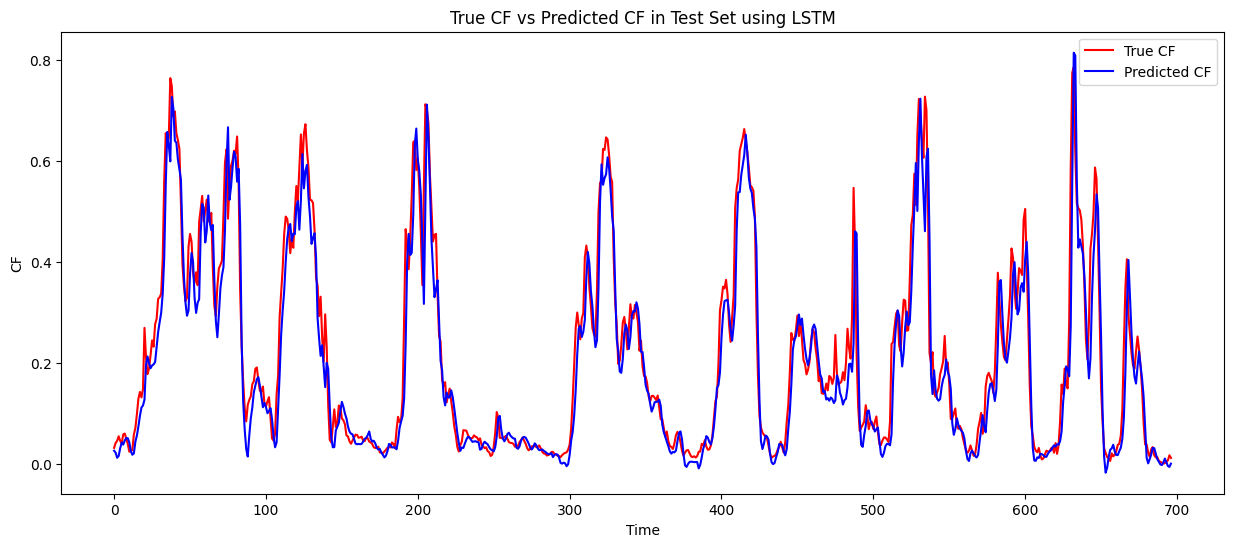

In [108]:
plt.figure(figsize=(15,6))
plt.plot(original, color = 'red', label = 'True CF')
plt.plot(pred, color = 'blue', label = 'Predicted CF')
plt.title('True CF vs Predicted CF in Test Set using LSTM')
plt.xlabel('Time')
plt.ylabel('CF')
plt.legend()
plt.show()

In [109]:
results_df = pd.DataFrame({
    'pred': pred,
    'original': original
})

In [110]:
results_df

,pred,original
0,0.025750,0.031467
1,0.021687,0.041133
2,0.011714,0.045355
3,0.015361,0.054444
4,0.030710,0.045355
...,...,...
692,0.010164,0.001292
693,0.002926,0.003553
694,-0.004493,0.006644
695,-0.006337,0.016772


In [111]:
mean_absolute_error(results_df['pred'], results_df['original'])

0.03847418017348697

### Prediction for Unseen Data

In [112]:
final_past2 = get_data_final_LSTM(data, pearson_spearman)
final_past2

,WS_2503597,WS_2508550,WS_2508545,MEAN_WS_ROLLING_AVG,STD_WS_ROLLING_AVG,P5_WS_ROLLING_AVG,P95_WS_ROLLING_AVG,SEASON_Fall,SEASON_Summer,SEASON_Winter,DAY_NIGHT_Daylight,DAY_NIGHT_Night,CF
DATETIME,,,,,,,,,,,,,
2019-08-07 01:00:00,11.75,11.92,11.55,9.254286,2.437052,4.0750,11.6790,0.0,1.0,0.0,0.0,1.0,0.605852
2019-08-07 02:00:00,11.67,11.99,11.73,8.919286,2.564288,3.1000,11.6590,0.0,1.0,0.0,0.0,1.0,0.564094
2019-08-07 03:00:00,11.37,11.90,11.73,8.690000,2.583354,2.6310,11.5625,0.0,1.0,0.0,0.0,1.0,0.532721
2019-08-07 04:00:00,11.25,11.84,11.74,8.560893,2.585717,2.7930,11.5725,0.0,1.0,0.0,0.0,1.0,0.495608
2019-08-07 06:00:00,10.77,11.35,11.22,8.165714,2.487341,2.9725,11.0715,0.0,1.0,0.0,1.0,0.0,0.384439
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-07 19:00:00,1.00,0.95,1.26,2.037500,1.284776,0.8500,3.4040,0.0,0.0,1.0,0.0,1.0,0.004494
2020-01-07 20:00:00,0.90,0.96,1.34,1.923393,1.208378,1.0300,3.0835,0.0,0.0,1.0,0.0,1.0,0.006143
2020-01-07 21:00:00,0.84,0.58,0.90,1.789732,1.197688,0.8665,3.0785,0.0,0.0,1.0,0.0,1.0,0.008399


In [113]:
def get_data_final_LSTM_2(data, correlation, rolling_window=1):
  ws_columns = [col for col in data.columns if col.startswith('WS_')]
  high_cor_list = correlation[correlation['WS_location'].isin(ws_columns)].iloc[:3]['WS_location'].to_list()
  data_final = pd.DataFrame()
  data_final[high_cor_list[0]] = data[high_cor_list[0]].shift().rolling(rolling_window, min_periods=1).mean()
  data_final[high_cor_list[1]] = data[high_cor_list[1]].shift().rolling(rolling_window, min_periods=1).mean()
  data_final[high_cor_list[2]] = data[high_cor_list[2]].shift().rolling(rolling_window, min_periods=1).mean()

  data_final['MEAN_WS_ROLLING_AVG'] = data['MEAN_WS'].shift().rolling(rolling_window, min_periods=1).mean()
  data_final['STD_WS_ROLLING_AVG'] = data['STD_WS'].shift().rolling(rolling_window, min_periods=1).mean()
  data_final['P5_WS_ROLLING_AVG'] = data['P5_WS'].shift().rolling(rolling_window, min_periods=1).mean()
  data_final['P95_WS_ROLLING_AVG'] = data['P95_WS'].shift().rolling(rolling_window, min_periods=1).mean()

  data_final['SEASON_Fall'] = data_final.index.month.isin([9,10,11])
  data_final['SEASON_Summer'] = data_final.index.month.isin([6,7,8])
  data_final['SEASON_Winter'] = data_final.index.month.isin([12,1,2])
  data_final['DAY_NIGHT_Daylight'] = data_final.index.hour.isin(range(6,18))
  data_final['DAY_NIGHT_Night'] = 1 - data_final['DAY_NIGHT_Daylight']
  data_final[['SEASON_Fall','SEASON_Summer','SEASON_Winter','DAY_NIGHT_Daylight','DAY_NIGHT_Night']] = data_final[['SEASON_Fall','SEASON_Summer','SEASON_Winter','DAY_NIGHT_Daylight','DAY_NIGHT_Night']].astype(int)
  data_final['CF'] = data['CF']

  return data_final

df_30_days_future = get_data_final_LSTM_2(predict, pearson_spearman)
df_30_days_future.shape

(93, 13)

In [114]:
df_30_days_future

,WS_2503597,WS_2508550,WS_2508545,MEAN_WS_ROLLING_AVG,STD_WS_ROLLING_AVG,P5_WS_ROLLING_AVG,P95_WS_ROLLING_AVG,SEASON_Fall,SEASON_Summer,SEASON_Winter,DAY_NIGHT_Daylight,DAY_NIGHT_Night,CF
DATETIME,,,,,,,,,,,,,
2020-01-09 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,1,NaN
2020-01-09 01:00:00,0.83,1.08,1.18,1.765982,1.216290,0.9300,3.1800,0,0,1,0,1,NaN
2020-01-09 02:00:00,1.11,0.92,1.24,1.895000,1.358101,0.8765,4.6650,0,0,1,0,1,NaN
2020-01-09 03:00:00,0.97,0.86,1.26,2.066429,1.425932,0.8710,5.2150,0,0,1,0,1,NaN
2020-01-09 04:00:00,1.05,1.19,1.60,2.300089,1.359500,0.8900,5.3050,0,0,1,0,1,NaN
2020-01-09 05:00:00,0.89,1.39,1.81,2.538661,1.428709,0.9200,5.3645,0,0,1,0,1,NaN
2020-01-09 06:00:00,1.44,3.03,3.36,2.978750,1.199287,1.1585,4.5045,0,0,1,1,0,NaN
2020-01-09 07:00:00,3.41,5.81,5.88,3.530536,1.857366,1.1900,6.1200,0,0,1,1,0,NaN
2020-01-09 08:00:00,5.69,7.68,7.64,4.004196,2.413177,1.5865,7.6290,0,0,1,1,0,NaN


In [115]:
df_30_days_past = final_past2.iloc[-30:,:]
df_30_days_past.tail()

,WS_2503597,WS_2508550,WS_2508545,MEAN_WS_ROLLING_AVG,STD_WS_ROLLING_AVG,P5_WS_ROLLING_AVG,P95_WS_ROLLING_AVG,SEASON_Fall,SEASON_Summer,SEASON_Winter,DAY_NIGHT_Daylight,DAY_NIGHT_Night,CF
DATETIME,,,,,,,,,,,,,
2020-01-07 19:00:00,1.00,0.95,1.26,2.037500,1.284776,0.8500,3.4040,0.0,0.0,1.0,0.0,1.0,0.004494
2020-01-07 20:00:00,0.90,0.96,1.34,1.923393,1.208378,1.0300,3.0835,0.0,0.0,1.0,0.0,1.0,0.006143
2020-01-07 21:00:00,0.84,0.58,0.90,1.789732,1.197688,0.8665,3.0785,0.0,0.0,1.0,0.0,1.0,0.008399
2020-01-07 22:00:00,1.06,0.90,0.97,1.802768,1.175470,0.9920,2.9185,0.0,0.0,1.0,0.0,1.0,0.015788
2020-01-07 23:00:00,0.81,0.84,0.79,1.799286,1.131968,0.8455,2.7370,0.0,0.0,1.0,0.0,1.0,0.011883


In [116]:
df_30_days_future["CF"] = 0
old_scaled_array = scaler.transform(df_30_days_past)
new_scaled_array = scaler.transform(df_30_days_future)
new_scaled_df = pd.DataFrame(new_scaled_array)
new_scaled_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,1.0,-0.004868
1,0.017848,0.033248,0.036885,0.023574,0.127325,0.055471,0.060376,0.0,0.0,1.0,0.0,1.0,-0.004868
2,0.031730,0.025064,0.039959,0.035321,0.159907,0.048033,0.143432,0.0,0.0,1.0,0.0,1.0,-0.004868
3,0.024789,0.021995,0.040984,0.050928,0.175492,0.047268,0.174194,0.0,0.0,1.0,0.0,1.0,-0.004868
4,0.028756,0.038875,0.058402,0.072202,0.160228,0.049910,0.179228,0.0,0.0,1.0,0.0,1.0,-0.004868


In [117]:
new_scaled_df.iloc[:,-1] = np.nan
pd.DataFrame(new_scaled_array).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,1.0,NaN
1,0.017848,0.033248,0.036885,0.023574,0.127325,0.055471,0.060376,0.0,0.0,1.0,0.0,1.0,NaN
2,0.031730,0.025064,0.039959,0.035321,0.159907,0.048033,0.143432,0.0,0.0,1.0,0.0,1.0,NaN
3,0.024789,0.021995,0.040984,0.050928,0.175492,0.047268,0.174194,0.0,0.0,1.0,0.0,1.0,NaN
4,0.028756,0.038875,0.058402,0.072202,0.160228,0.049910,0.179228,0.0,0.0,1.0,0.0,1.0,NaN


In [118]:
full_df = pd.concat([pd.DataFrame(old_scaled_array),pd.DataFrame(new_scaled_array)]).reset_index().drop(["index"],axis=1)
full_df

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.204264,0.326854,0.311988,0.189772,0.413425,0.063951,0.262787,0.0,0.0,1.0,0.0,1.0,0.405241
1,0.329202,0.411253,0.402152,0.231547,0.540995,0.037536,0.342795,0.0,0.0,1.0,0.0,1.0,0.293930
2,0.396133,0.475192,0.468750,0.268339,0.685926,0.015293,0.417098,0.0,0.0,1.0,0.0,1.0,0.257826
3,0.426376,0.493095,0.488217,0.275785,0.680271,0.038788,0.432395,0.0,0.0,1.0,0.0,1.0,0.220177
4,0.406544,0.490537,0.488217,0.276793,0.646451,0.049910,0.429151,0.0,0.0,1.0,0.0,1.0,0.195054
5,0.340109,0.474680,0.473873,0.278322,0.639852,0.074308,0.420398,0.0,0.0,1.0,0.0,1.0,0.188318
6,0.362419,0.501790,0.502561,0.299132,0.681047,0.104268,0.447356,0.0,0.0,1.0,0.0,1.0,0.221953
7,0.347050,0.487468,0.485143,0.290076,0.647430,0.105033,0.429151,0.0,0.0,1.0,0.0,1.0,0.252105
8,0.265245,0.416368,0.414447,0.253739,0.511576,0.088975,0.356246,0.0,0.0,1.0,0.0,1.0,0.226221
9,0.261775,0.424041,0.425205,0.270144,0.519859,0.087446,0.366761,0.0,0.0,1.0,0.0,1.0,0.192908


In [119]:
for i in range(full_df.shape[1]-1):
    full_df[i] = full_df[i].fillna(method='ffill')
full_df

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.204264,0.326854,0.311988,0.189772,0.413425,0.063951,0.262787,0.0,0.0,1.0,0.0,1.0,0.405241
1,0.329202,0.411253,0.402152,0.231547,0.540995,0.037536,0.342795,0.0,0.0,1.0,0.0,1.0,0.293930
2,0.396133,0.475192,0.468750,0.268339,0.685926,0.015293,0.417098,0.0,0.0,1.0,0.0,1.0,0.257826
3,0.426376,0.493095,0.488217,0.275785,0.680271,0.038788,0.432395,0.0,0.0,1.0,0.0,1.0,0.220177
4,0.406544,0.490537,0.488217,0.276793,0.646451,0.049910,0.429151,0.0,0.0,1.0,0.0,1.0,0.195054
5,0.340109,0.474680,0.473873,0.278322,0.639852,0.074308,0.420398,0.0,0.0,1.0,0.0,1.0,0.188318
6,0.362419,0.501790,0.502561,0.299132,0.681047,0.104268,0.447356,0.0,0.0,1.0,0.0,1.0,0.221953
7,0.347050,0.487468,0.485143,0.290076,0.647430,0.105033,0.429151,0.0,0.0,1.0,0.0,1.0,0.252105
8,0.265245,0.416368,0.414447,0.253739,0.511576,0.088975,0.356246,0.0,0.0,1.0,0.0,1.0,0.226221
9,0.261775,0.424041,0.425205,0.270144,0.519859,0.087446,0.366761,0.0,0.0,1.0,0.0,1.0,0.192908


In [120]:
# # Delete to update
# full_df = full_df[[4] + list(full_df.columns[:-1])]

In [121]:
full_df_scaled_array = full_df.values
full_df_scaled_array.shape

(123, 13)

In [122]:
all_data = []
time_step = 30
for i in range(time_step, len(full_df_scaled_array)):
    full_df_scaled_array = full_df.values
    data_x = []
    data_x.append(full_df_scaled_array[i-time_step:i, 0:full_df_scaled_array.shape[1]])
    data_x = np.array(data_x)
    prediction = my_model.predict(data_x)
    all_data.append(prediction)
    # full_df.iloc[i,0] = prediction
    full_df.iloc[i, -1] = prediction # Corrected


1/1 [==============================] - 0s 34ms/step


In [123]:
new_array = np.array(all_data)
new_array = new_array.reshape(-1,1)
prediction_copies_array = np.repeat(new_array, 13, axis=-1)
y_pred_future_30_days = np.reshape(prediction_copies_array, (len(new_array), 13))[:, 0]
pd.DataFrame(y_pred_future_30_days).to_excel('final2.xlsx')
print(y_pred_future_30_days)

[ 2.50723213e-03  1.25904754e-03  1.03102624e-03  6.12509996e-03
  1.31901540e-02  1.98757276e-02  2.60423906e-02  1.30273215e-02
  1.46493651e-02  3.18207592e-02  4.34281267e-02  3.14873233e-02
 -3.52203101e-03 -2.68684402e-02 -2.43910328e-02 -5.76032698e-03
  2.27000676e-02  6.85410351e-02  1.51972160e-01  2.22465664e-01
  2.53596693e-01  2.75304556e-01  2.72449553e-01  2.46972382e-01
  2.14068025e-01  2.04283088e-01  2.01707721e-01  2.04942077e-01
  2.02246696e-01  1.94521934e-01  1.84103161e-01  1.41226470e-01
  7.79576898e-02  2.84040049e-02  1.85419619e-03  1.05574727e-04
  1.47086345e-02  4.08675447e-02  6.65460452e-02  8.07214230e-02
  8.42734724e-02  7.54885972e-02  6.71164170e-02  6.02971651e-02
  4.94625568e-02  3.50693949e-02  2.55332850e-02  1.87649280e-02
  1.64686590e-02  1.34730935e-02  1.00276023e-02  9.22659412e-03
  9.83643532e-03  1.20114908e-02  1.49429254e-02  4.49096411e-03
 -2.27466226e-03 -5.21886349e-03 -7.91452080e-03 -1.19940788e-02
 -1.90064609e-02 -2.53819

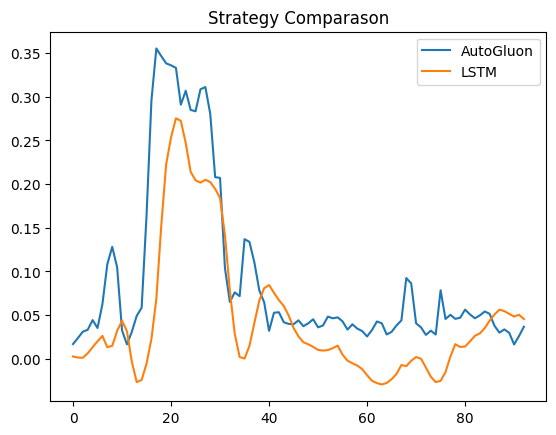

In [124]:
plt.plot(final_result['CF'], label='AutoGluon')
plt.plot(y_pred_future_30_days, label='LSTM')
plt.title('Strategy Comparason')
plt.legend()
plt.show()